# Exploring Data from multiple sources

In [ ]:
%pip install xgboost
%pip install xarray
%pip install tenserflow
%pip install shapely
%pip install geopandas

Note: you may need to restart the kernel to use updated packages.
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.9 MB/s eta 0:00:00
Using cached packaging-25.0-py3-none-any.whl (66 kB)
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xarray]2m1/2 [xarray]
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement tenserflow (from versions: none)
ERROR: No matching distribution found for tenserflow
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 11.2 MB/s eta 0:00:00a 0:0

In [4]:
import csv
import pandas as pd
import os
import xarray as xr
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
# import rasterio
from datetime import datetime
import joblib

### San Bernardino County, CA data points on drought
combined two datasets --> one with observed, monitored drought data and one with replicated, "predicted" drought data. Because the monitored drought data only starts from 2000, we decided to take the "historical" drought data from 1950 to 1999 and concatenate it with the observed dataset.

In [5]:
path = os.getcwd()

new_drought_df = pd.read_csv(path + '/data/SB_DroughtConditions.csv')
# print(new_drought_df.head())

# subset data so that it only includes dates from 2000 - 2024
# print(new_drought_df.dtypes)
new_drought_df = new_drought_df[new_drought_df['MapDate'] >= 20000101]
new_drought_df = new_drought_df[new_drought_df['MapDate'] <= 20241231]
# print(new_drought_df.head())

historical_drought_df = pd.read_csv(path + '/data/SB_historical_drought.csv')
# print(historical_drought_df.head())

# extract needed columns about drought
historical_drought_df = historical_drought_df[['DATE', 'D0', 'D1', 'D2', 'D3', 'D4']]
# print(historical_drought_df.dtypes)
# splice date string to only include yyyymmdd
historical_drought_df['DATE'] = historical_drought_df['DATE'].str[2:]
# subset data so that it only includes dates from 1950 - 1999
historical_drought_df = historical_drought_df[historical_drought_df['DATE'] >= "19500101"]
historical_drought_df = historical_drought_df[historical_drought_df['DATE'] <= "19991231"]

historical_drought_df.rename(columns={'DATE': 'date'}, inplace=True)
# # convert date column to datetime format
# historical_drought_df['date'] = pd.to_datetime(historical_drought_df['date'])
# # format the datetime objects to 'yyyy-mm'
# historical_drought_df['date'] = historical_drought_df['date'].dt.strftime('%Y-%m')
historical_drought_df.reset_index(drop=True, inplace=True)
# print(historical_drought_df.head())

# combine datasets
new_drought_df.rename(columns={'MapDate': 'date'}, inplace=True)
new_drought_df = new_drought_df[['date', 'D0', 'D1', 'D2', 'D3', 'D4']]
# print(new_drought_df.head())

# rename column DATE of historical_drought_df
historical_drought_df.rename(columns={'DATE': 'date'}, inplace=True)

# merge datasets
drought_df = pd.concat([historical_drought_df, new_drought_df], axis=0)
print(drought_df.head())

       date    D0    D1    D2    D3    D4
0  19500101  90.1  83.9  57.9  40.8  16.1
1  19500201  92.7  89.4  72.4  50.8  13.1
2  19500301  95.8  90.4  68.8  48.5   8.3
3  19500401  96.1  90.9  70.6  43.6   0.2
4  19500501  97.5  90.8  76.8  29.2   0.1


In [ ]:
drought_df.to_csv(path + "/data/SB_drought_labels.csv", index=False)

#### take drought_df with all drought labels and group by month

In [7]:
# convert date column to datetime format
drought_df['date'] = pd.to_datetime(drought_df['date'])

drought_df = drought_df.groupby(drought_df['date'].dt.to_period('M'))[['D0', 'D1', 'D2', 'D3', 'D4']].mean().reset_index()
print(drought_df.head())

# format the datetime objects to 'yyyy-mm'
drought_df['date'] = drought_df['date'].dt.strftime('%Y-%m')

# make into csv and store in historical_all
new_dir = path + '/data/historical_all'
os.makedirs(new_dir, exist_ok=True)

# make all df into csv files in new directory
new_filepath = os.path.join(new_dir, "SB_historical_drought_labels.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(drought_df)

      date    D0    D1    D2    D3    D4
0  1950-01  90.1  83.9  57.9  40.8  16.1
1  1950-02  92.7  89.4  72.4  50.8  13.1
2  1950-03  95.8  90.4  68.8  48.5   8.3
3  1950-04  96.1  90.9  70.6  43.6   0.2
4  1950-05  97.5  90.8  76.8  29.2   0.1


Accuracy is variable. Goes form 0.74 to 0.9. Should do multiple runs of model? And should make model more robust. Maybe more data.

this is more classification --> change to prediction. Given this time period, predict the next week?

take weather, precipitation, and  --> datasets that give data on future date's climate

Do this after getting data --> causality with DoWhy --> codes up DAG

find the years that may have bad droughts/worst drought conditions

dew point (single value) if we're measuring one day (random day i.e. Jan 1st, 2066)
dew point if we have the previous week --> predict the next week (base off of trend/variability of temp, precip, dew point, humidity)

groundwater data for san bernardino

extract ppt, dp, etc. from tif file (maybe didn't do in the first run? -- find out)

label droughts by type (flash drought for times when we go from D0 to Dk in a short period of time)

prism data format explanation: https://prism.oregonstate.edu/formats/

### Drought data labels by month

In [8]:
# convert drought_df['DATE'] row to datetime format
drought_df['date'] = pd.to_datetime(drought_df['date'])
print(drought_df.head())

# group data by month and get most frequent value per month
drought_monthlydf = drought_df.groupby(drought_df['date'].dt.to_period('M'))[['D0', 'D1', 'D2', 'D3', 'D4']].mean().reset_index()

# drought_monthlydf.columns = ['date', 'D0', 'D1', 'D2', 'D3', 'D4']
print(drought_monthlydf.head())


        date    D0    D1    D2    D3    D4
0 1950-01-01  90.1  83.9  57.9  40.8  16.1
1 1950-02-01  92.7  89.4  72.4  50.8  13.1
2 1950-03-01  95.8  90.4  68.8  48.5   8.3
3 1950-04-01  96.1  90.9  70.6  43.6   0.2
4 1950-05-01  97.5  90.8  76.8  29.2   0.1
      date    D0    D1    D2    D3    D4
0  1950-01  90.1  83.9  57.9  40.8  16.1
1  1950-02  92.7  89.4  72.4  50.8  13.1
2  1950-03  95.8  90.4  68.8  48.5   8.3
3  1950-04  96.1  90.9  70.6  43.6   0.2
4  1950-05  97.5  90.8  76.8  29.2   0.1


In [9]:
# convert to csv file
drought_monthlydf.to_csv("SB_monthly_drought_labels.csv", index=False)

### Get 1950-2013 observed historical data from livneh_vic and combine with predicted values from loca_vic HadGEM2-ES with rcp 8.5 to assume worst case baseline for carbon emissions for 2014-2024
different model information: 
1. HadGEM2-ES (warm/dry)
2. CanESM2 (average)
3. CNRM-CM5 (cooler/wetter)
4. MIROC5 the model least like the others to improve coverage of the range of outcomes

Change historical 1950-2013 data from daily to monthly to converge with loca-vic predictive data

In [10]:
# change daily to monthly
daily_airtemp2013 = pd.read_csv(path + '/data/livneh_vic/airtemp_daily.csv')
daily_baseflow2013 = pd.read_csv(path + '/data/livneh_vic/baseflow_daily.csv')
daily_ev2013 = pd.read_csv(path + '/data/livneh_vic/evapotranspiration_daily.csv')
daily_rainfall2013 = pd.read_csv(path + '/data/livneh_vic/rainfall_daily.csv')
daily_runoff2013 = pd.read_csv(path + '/data/livneh_vic/runoff_daily.csv')
daily_snowfall2013 = pd.read_csv(path + '/data/livneh_vic/snowfall_daily.csv')
daily_snowwater2013 = pd.read_csv(path + '/data/livneh_vic/snowwater_daily.csv')
daily_sm2013 = pd.read_csv(path + '/data/livneh_vic/soilmoisture_daily.csv')

dailydf = {"airtemp": daily_airtemp2013, 
           "baseflow": daily_baseflow2013, 
           "ev": daily_ev2013, 
           "rainfall": daily_rainfall2013, 
           "runoff": daily_runoff2013, 
           "snowfall": daily_snowfall2013, 
           "snowwater": daily_snowwater2013,
           "sm": daily_sm2013}

monthly2013_df = {}

for var, df in dailydf.items():
    df['date'] = pd.to_datetime(df['time'])
    column = df.columns[1]
    new_df = df.groupby(df['date'].dt.to_period('M'))[column].mean().reset_index()
    new_df.rename(columns={column: var}, inplace=True)
    # print(new_df.head())

    monthly2013_df[f"monthly_{var}2013"] = new_df

monthly_airtemp2013 = monthly2013_df['monthly_airtemp2013']
monthly_baseflow2013 = monthly2013_df['monthly_baseflow2013']
monthly_ev2013 = monthly2013_df['monthly_ev2013']
monthly_rainfall2013 = monthly2013_df['monthly_rainfall2013']
monthly_runoff2013 = monthly2013_df['monthly_runoff2013']
monthly_sm2013 = monthly2013_df['monthly_sm2013']
monthly_snowfall2013 = monthly2013_df['monthly_snowfall2013']
monthly_snowwater2013 = monthly2013_df['monthly_snowwater2013']

/var/folders/6f/_xgb6f4s4m7cnsr9l19ynqg40000gn/T/ipykernel_14316/1019791965.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_df = df.groupby(df['date'].dt.to_period('M'))[column].mean().reset_index()
/var/folders/6f/_xgb6f4s4m7cnsr9l19ynqg40000gn/T/ipykernel_14316/1019791965.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_df = df.groupby(df['date'].dt.to_period('M'))[column].mean().reset_index()
/var/folders/6f/_xgb6f4s4m7cnsr9l19ynqg40000gn/T/ipykernel_14316/1019791965.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_df = df.groupby(df['date'].dt.to_period('M'))[column].mean().reset_index()
/var/folders/6f/_xgb6f4s4m7cnsr9l19ynqg40000gn/T/ipykernel_14316/1019791965.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_df = df.groupby(df['date'].dt.to_period('M'))[colum

load loca-vic data and merge with the 1950-2013 dataa

In [11]:
model = "HadGEM2-ES"
emissions = "rcp85"
monthlydf_names = ["airtemp", "baseflow", "ev", "rainfall", "runoff", "snowfall", "snowwater", "sm"]

monthly2024_df = {}
for t in monthlydf_names:
    new_df = pd.read_csv(path + f'/data/projected_{t}_2006_2099_monthly/{t}_month_{model}_{emissions}.csv')
    column = new_df.columns[1]
    new_df.rename(columns={column: t}, inplace=True)

    new_df.rename(columns={'time': 'date'}, inplace=True)
    
    # convert date column to datetime format
    new_df['date'] = pd.to_datetime(new_df['date'])
    
    # filter data from 2014 to 2024
    new_df = new_df[(new_df['date'].dt.year >= 2014) & (new_df['date'].dt.year <= 2024)]
    
    # format the datetime objects to 'yyyy-mm'
    new_df['date'] = new_df['date'].dt.strftime('%Y-%m')

    monthly2024_df[f"monthly_{t}2024"] = new_df

monthly_airtemp2024 = monthly2024_df['monthly_airtemp2024']
monthly_baseflow2024 = monthly2024_df['monthly_baseflow2024']
monthly_ev2024 = monthly2024_df['monthly_ev2024']
monthly_rainfall2024 = monthly2024_df['monthly_rainfall2024']
monthly_runoff2024 = monthly2024_df['monthly_runoff2024']
monthly_sm2024 = monthly2024_df['monthly_sm2024']
monthly_snowfall2024 = monthly2024_df['monthly_snowfall2024']
monthly_snowwater2024 = monthly2024_df['monthly_snowwater2024']

In [ ]:
# merge with monthly_{var_type}2013

airtemp_df = pd.concat([monthly_airtemp2013, monthly_airtemp2024], axis=0)
baseflow_df = pd.concat([monthly_baseflow2013, monthly_baseflow2024], axis=0)
ev_df = pd.concat([monthly_ev2013, monthly_ev2024], axis=0)
rainfall_df = pd.concat([monthly_rainfall2013, monthly_rainfall2024], axis=0)
runoff_df = pd.concat([monthly_runoff2013, monthly_runoff2024], axis=0)
sm_df = pd.concat([monthly_sm2013, monthly_sm2024], axis=0)
snowfall_df = pd.concat([monthly_snowfall2013, monthly_snowfall2024], axis=0)
snowwater_df = pd.concat([monthly_snowwater2013, monthly_snowwater2024], axis=0)

print(airtemp_df.head())
print(baseflow_df.head())
print(ev_df.head())
print(rainfall_df.head())
print(runoff_df.head())
print(sm_df.head())
print(snowfall_df.head())
print(snowwater_df.head())

      date    airtemp
0  1950-01   5.469246
1  1950-02  11.261756
2  1950-03  13.522296
3  1950-04  18.837398
4  1950-05  20.676498
      date  baseflow
0  1950-01  0.036113
1  1950-02  0.036952
2  1950-03  0.033402
3  1950-04  0.039273
4  1950-05  0.029522
      date        ev
0  1950-01  0.712696
1  1950-02  0.947727
2  1950-03  0.763165
3  1950-04  0.317350
4  1950-05  0.155867
      date  rainfall
0  1950-01  0.207599
1  1950-02  0.446101
2  1950-03  0.412884
3  1950-04  0.112882
4  1950-05  0.021634
      date    runoff
0  1950-01  0.011982
1  1950-02  0.028984
2  1950-03  0.010870
3  1950-04  0.007152
4  1950-05  0.000562
      date         sm
0  1950-01  11.695956
1  1950-02   9.503363
2  1950-03   7.893302
3  1950-04   6.434203
4  1950-05   5.557502
      date  snowfall
0  1950-01  0.139311
1  1950-02  0.023380
2  1950-03  0.025884
3  1950-04  0.027177
4  1950-05  0.002887
      date  snowwater
0  1950-01   0.707678
1  1950-02   0.467992
2  1950-03   0.215861
3  1950-04   0.110

Merge drought levels data with variable data

In [13]:
from functools import reduce

# merge all variables together into dataframe
dfs = [airtemp_df, baseflow_df, ev_df, rainfall_df, runoff_df, sm_df, snowfall_df, snowwater_df]
historical_all_df = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
print(historical_all_df.head())

# new_filepath = os.path.join(new_dir, "all_historical.csv")
# with open(new_filepath, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerows(historical_all_df)

      date    airtemp  baseflow        ev  rainfall    runoff         sm  \
0  1950-01   5.469246  0.036113  0.712696  0.207599  0.011982  11.695956   
1  1950-02  11.261756  0.036952  0.947727  0.446101  0.028984   9.503363   
2  1950-03  13.522296  0.033402  0.763165  0.412884  0.010870   7.893302   
3  1950-04  18.837398  0.039273  0.317350  0.112882  0.007152   6.434203   
4  1950-05  20.676498  0.029522  0.155867  0.021634  0.000562   5.557502   

   snowfall  snowwater  
0  0.139311   0.707678  
1  0.023380   0.467992  
2  0.025884   0.215861  
3  0.027177   0.110780  
4  0.002887   0.026390  


In [14]:
print(drought_df.head())

drought_df['date'] = pd.to_datetime(drought_df['date'], format='%Y-%m')
historical_all_df['date'] = pd.to_datetime(historical_all_df['date'], format='%Y-%m')

# merge historical_all_df with drought_df
final_historical_df = pd.merge(historical_all_df, drought_df, on='date', how='inner')
print(final_historical_df.head())

        date    D0    D1    D2    D3    D4
0 1950-01-01  90.1  83.9  57.9  40.8  16.1
1 1950-02-01  92.7  89.4  72.4  50.8  13.1
2 1950-03-01  95.8  90.4  68.8  48.5   8.3
3 1950-04-01  96.1  90.9  70.6  43.6   0.2
4 1950-05-01  97.5  90.8  76.8  29.2   0.1
        date    airtemp  baseflow        ev  rainfall    runoff         sm  \
0 1950-01-01   5.469246  0.036113  0.712696  0.207599  0.011982  11.695956   
1 1950-02-01  11.261756  0.036952  0.947727  0.446101  0.028984   9.503363   
2 1950-03-01  13.522296  0.033402  0.763165  0.412884  0.010870   7.893302   
3 1950-04-01  18.837398  0.039273  0.317350  0.112882  0.007152   6.434203   
4 1950-05-01  20.676498  0.029522  0.155867  0.021634  0.000562   5.557502   

   snowfall  snowwater    D0    D1    D2    D3    D4  
0  0.139311   0.707678  90.1  83.9  57.9  40.8  16.1  
1  0.023380   0.467992  92.7  89.4  72.4  50.8  13.1  
2  0.025884   0.215861  95.8  90.4  68.8  48.5   8.3  
3  0.027177   0.110780  96.1  90.9  70.6  43.6   0.2 

In [15]:
final_historical_df.to_csv("final_historical.csv")

## 1950-2013
Merge 1950-2013 variable data with drought data only until **2013**

In [16]:
cv_historical_df = final_historical_df.copy()

cv_historical_df['date'] = cv_historical_df['date'].apply(
    lambda x: x.to_timestamp() if isinstance(x, pd.Period) else pd.to_datetime(x)
)

cv_historical_df = cv_historical_df[cv_historical_df['date'].dt.year < 2014]

print(cv_historical_df)

          date    airtemp  baseflow        ev  rainfall    runoff         sm  \
0   1950-01-01   5.469246  0.036113  0.712696  0.207599  0.011982  11.695956   
1   1950-02-01  11.261756  0.036952  0.947727  0.446101  0.028984   9.503363   
2   1950-03-01  13.522296  0.033402  0.763165  0.412884  0.010870   7.893302   
3   1950-04-01  18.837398  0.039273  0.317350  0.112882  0.007152   6.434203   
4   1950-05-01  20.676498  0.029522  0.155867  0.021634  0.000562   5.557502   
..         ...        ...       ...       ...       ...       ...        ...   
763 2013-08-01  28.717042  0.026354  0.347947  0.561113  0.008274   6.916853   
764 2013-09-01  25.199694  0.026135  0.523672  0.312458  0.004821   8.541084   
765 2013-10-01  17.191673  0.025938  0.080414  0.072593  0.001138   5.760195   
766 2013-11-01  12.775977  0.025719  0.278565  0.710123  0.015111   8.983794   
767 2013-12-01   8.067449  0.025587  0.264997  0.076278  0.001941  11.967273   

         snowfall  snowwater        D0 

## LSTM

Epoch 1/200


/opt/homebrew/Caskroom/mambaforge/base/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2311 - mae: 0.3374 - val_loss: 0.0831 - val_mae: 0.2274
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0690 - mae: 0.1856 - val_loss: 0.0466 - val_mae: 0.1493
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0556 - mae: 0.1582 - val_loss: 0.0531 - val_mae: 0.1554
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0435 - mae: 0.1340 - val_loss: 0.0370 - val_mae: 0.1267
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0371 - mae: 0.1247 - val_loss: 0.0411 - val_mae: 0.1403
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0376 - mae: 0.1267 - val_loss: 0.0581 - val_mae: 0.1764
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0347 - mae: 0.1194 - val_loss: 0.0437 - val_mae: 0.1481
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0506 - mae: 0.1499 - val_loss: 0.0553 - val_mae: 0.1716
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0342 - mae: 0.

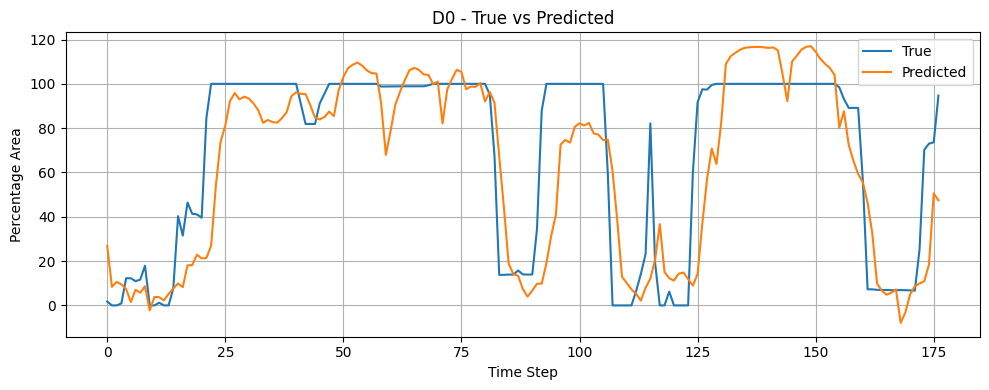

D1 - MAE: 13.2240, R²: 0.7918


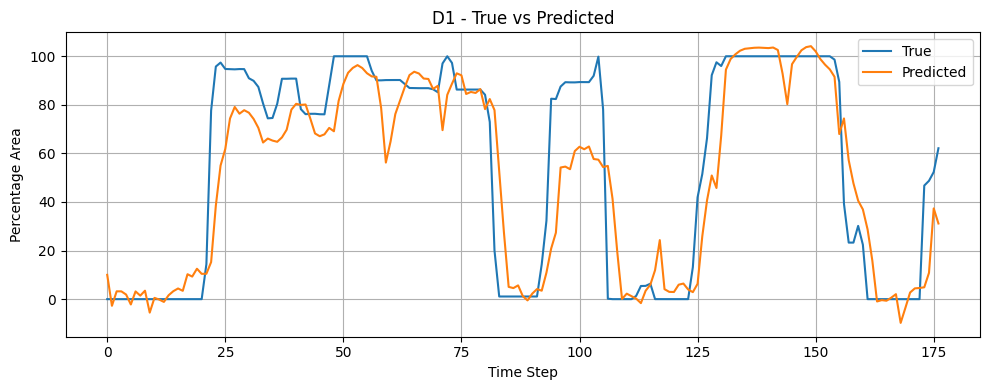

D2 - MAE: 15.5676, R²: 0.6937


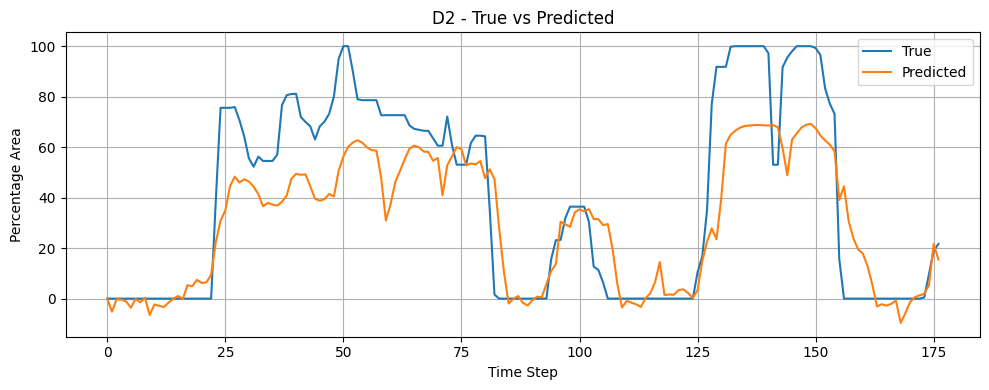

D3 - MAE: 12.9526, R²: 0.3968


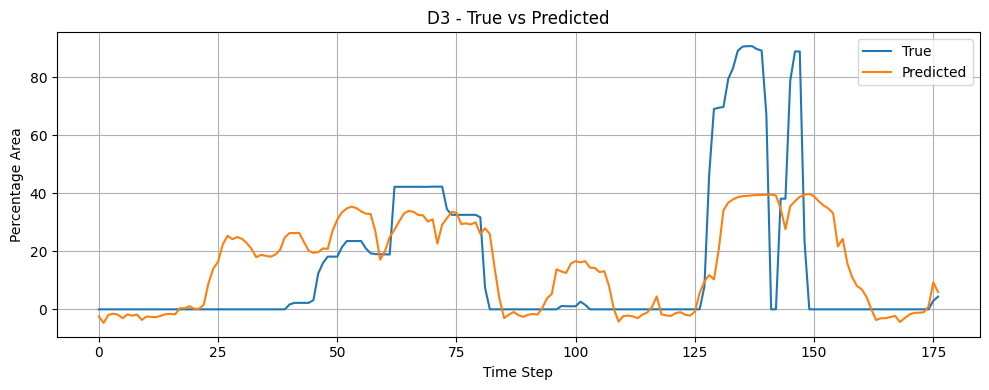

D4 - MAE: 3.0313, R²: -0.1761


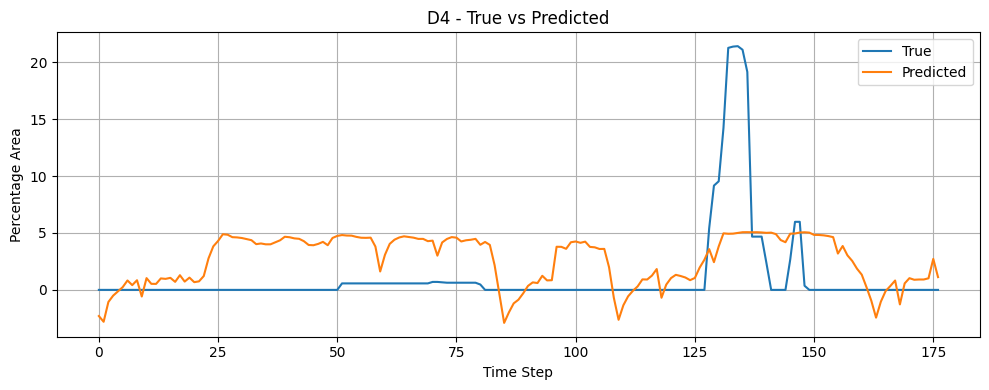

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Step 1: Preprocessing and Feature Engineering
# Assuming final_historical_df is your dataframe
final_historical_df['date'] = pd.to_datetime(final_historical_df['date'])

# Create Lag Features (1-step lag for D0, D1, D2, D3, D4)
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    for lag in range(1, 4):  # Lag 1, 2, 3
        final_historical_df[f'{col}_lag{lag}'] = final_historical_df[col].shift(lag)

# Create Rolling Mean and Std Features (using a window of 7 days, for example)
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    final_historical_df[f'{col}_rolling_mean'] = final_historical_df[col].rolling(window=7).mean()
    final_historical_df[f'{col}_rolling_std'] = final_historical_df[col].rolling(window=7).std()

# Drop NaN values generated by shifting and rolling operations
final_historical_df = final_historical_df.dropna()

# Step 2: Prepare Features and Targets
features = final_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
target = final_historical_df[['D0', 'D1', 'D2', 'D3', 'D4']]

# Normalize Features and Targets
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(features)
y_scaled = target_scaler.fit_transform(target)

# Step 3: Create Sequences for LSTM
SEQ_LENGTH = 12 # 12 time steps (e.g., 12 weeks of data)
# 12 = all r^2 are above 0 (d3,4 improved)

X_seq, y_seq = [], []
for i in range(len(X_scaled) - SEQ_LENGTH):
    X_seq.append(X_scaled[i:i+SEQ_LENGTH])  # Sequence of features
    y_seq.append(y_scaled[i+SEQ_LENGTH])  # Next time step prediction

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Step 4: Train/Test Split
split_idx = int(0.8 * len(X_seq))  # 80% train, 20% test
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Step 5: Build and Train the LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(5)  # Output size matches D0, D1, D2, D3, D4
])

learning_rate = 0.05
# Compile the model with the custom learning rate
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Step 6: Evaluate the Model
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and true labels to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_orig = target_scaler.inverse_transform(y_test)

# Calculate MAE and R² for each drought level
from sklearn.metrics import mean_absolute_error, r2_score

for i, category in enumerate(['D0', 'D1', 'D2', 'D3', 'D4']):
    mae = mean_absolute_error(y_test_orig[:, i], y_pred[:, i])
    r2 = r2_score(y_test_orig[:, i], y_pred[:, i])
    print(f"{category} - MAE: {mae:.4f}, R²: {r2:.4f}")
    
    # Plot predictions vs true values
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_orig[:, i], label='True')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.title(f"{category} - True vs Predicted")
    plt.xlabel("Time Step")
    plt.ylabel("Percentage Area")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Random Forest and XgBoost


====== RandomForest Results ======
D0 - MAE: 9.8784, R²: 0.8326


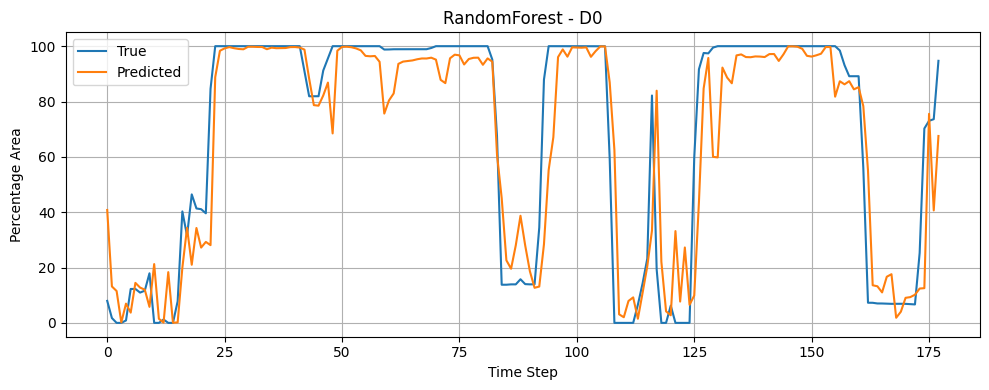

D1 - MAE: 8.7372, R²: 0.8924


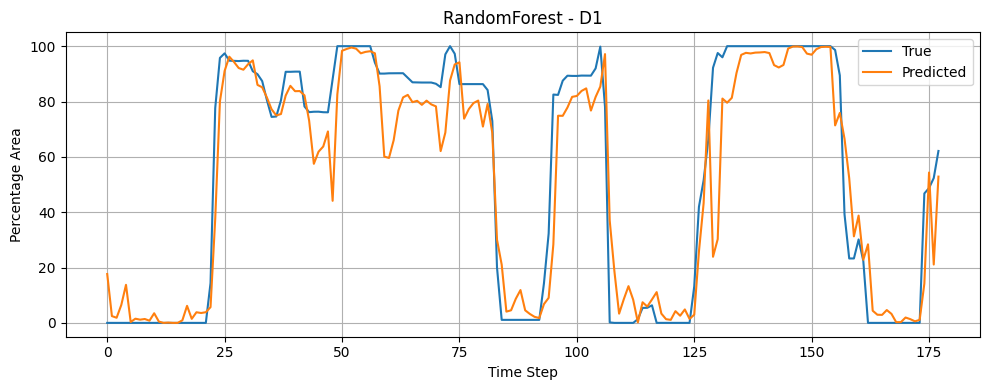

D2 - MAE: 10.9304, R²: 0.8059


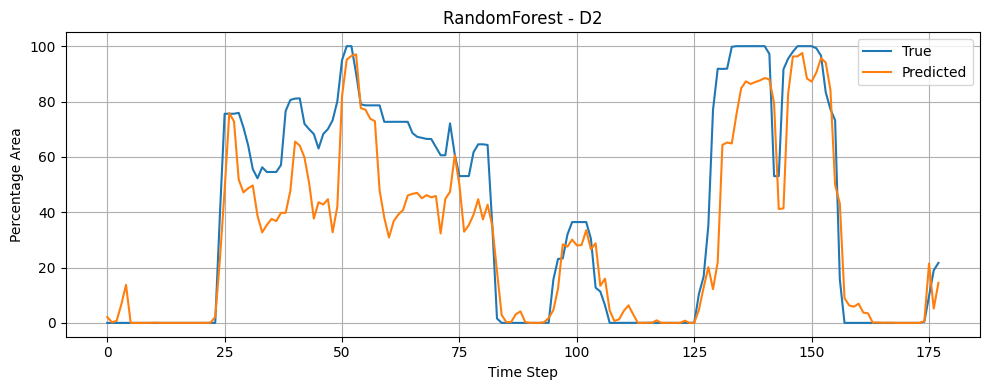

D3 - MAE: 7.4535, R²: 0.6762


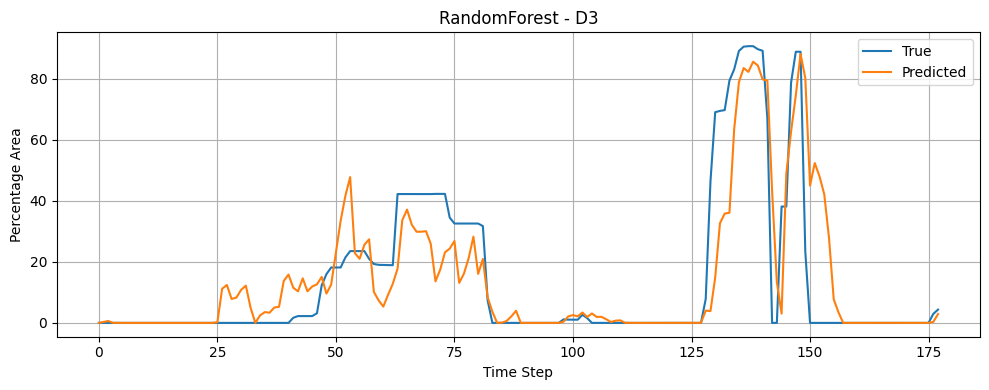

D4 - MAE: 0.8256, R²: 0.5217


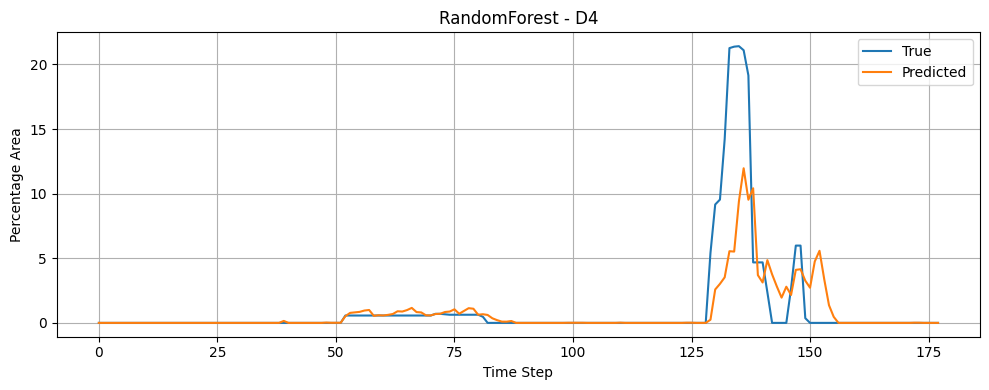


====== XGBoost Results ======
D0 - MAE: 10.1078, R²: 0.8280


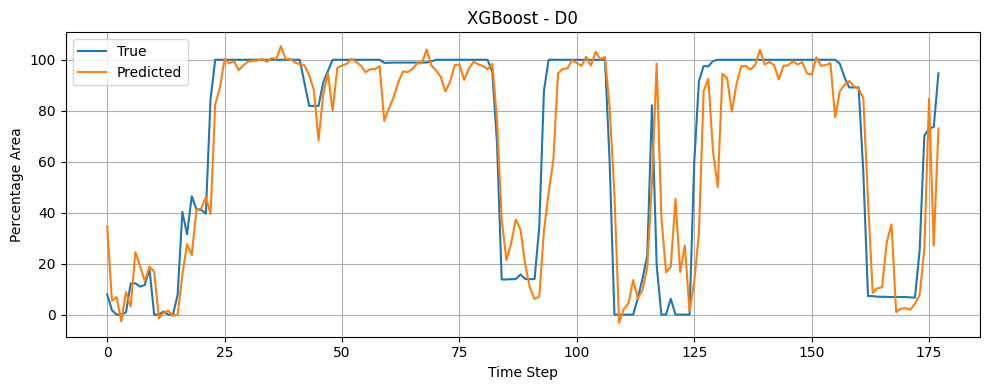

D1 - MAE: 8.8601, R²: 0.8647


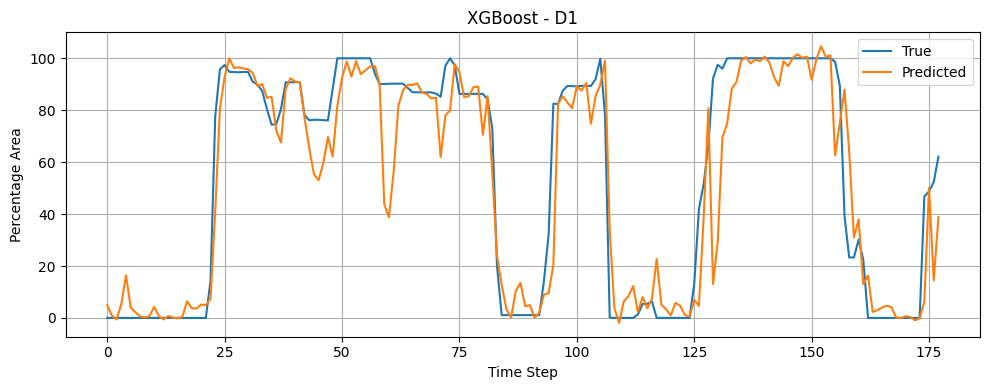

D2 - MAE: 13.7330, R²: 0.6863


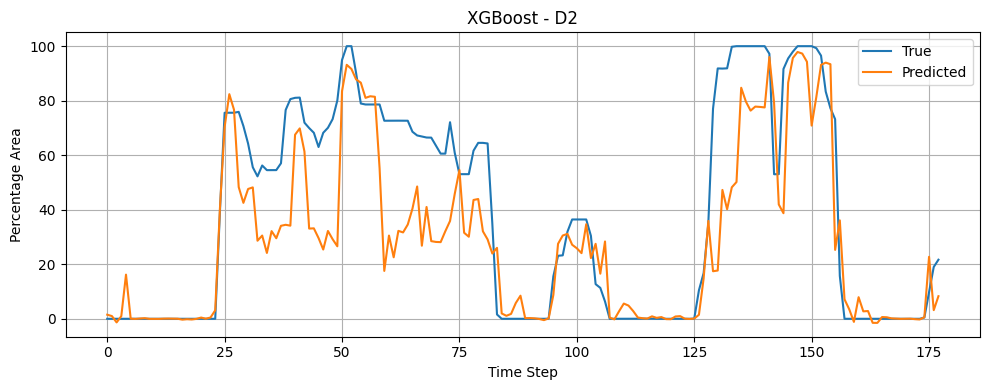

D3 - MAE: 7.8088, R²: 0.6084


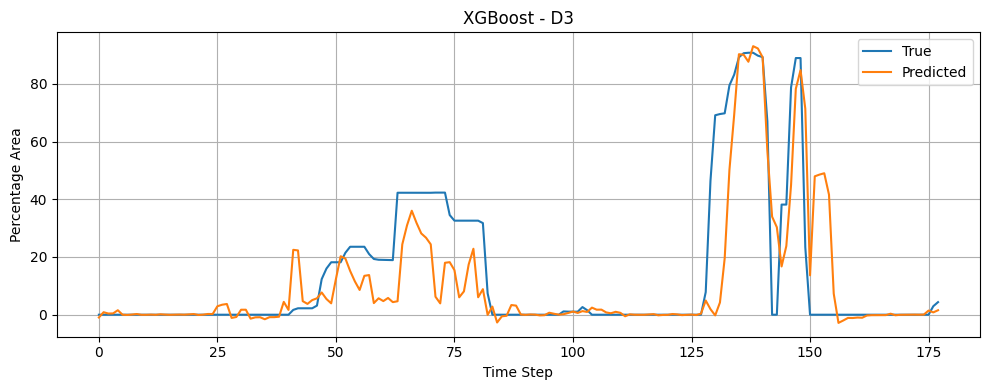

D4 - MAE: 0.9671, R²: 0.1554


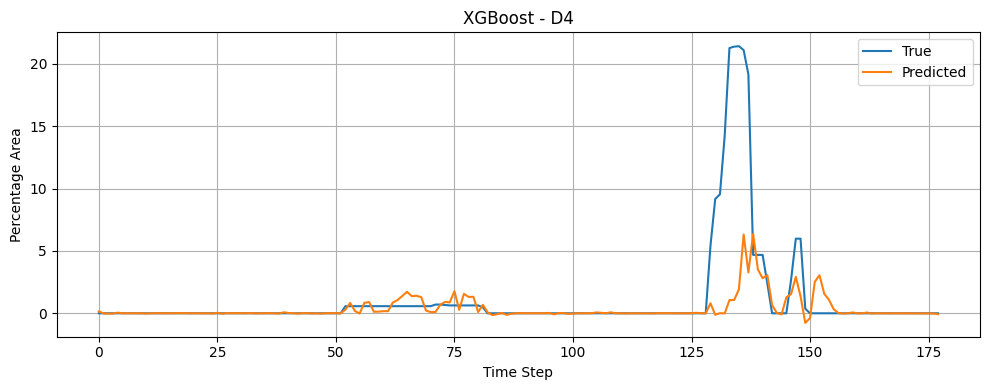

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Feature Engineering
df = final_historical_df.copy()
df['date'] = pd.to_datetime(df['date'])

# Create lag features
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    for lag in range(1, 4):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Create rolling stats (7-day window)
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    df[f'{col}_roll_mean'] = df[col].rolling(window=7).mean()
    df[f'{col}_roll_std'] = df[col].rolling(window=7).std()

# Drop NaNs caused by lag and rolling
df = df.dropna().reset_index(drop=True)

# Step 2: Features and Targets
X = df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
y = df[['D0', 'D1', 'D2', 'D3', 'D4']]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Time-aware split (80% train, 20% test)
split_idx = int(0.8 * len(X))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx].values, y[split_idx:].values

# Step 3: Fit and Evaluate Models
results = {}

for model_name, model_class in {
    'RandomForest': RandomForestRegressor,
    'XGBoost': XGBRegressor
}.items():
    
    print(f"\n====== {model_name} Results ======")
    model_results = {}
    
    for i, target in enumerate(['D0', 'D1', 'D2', 'D3', 'D4']):
        model = model_class(n_estimators=100, random_state=42)
        model.fit(X_train, y_train[:, i])
        y_pred = model.predict(X_test)
        
        mae = mean_absolute_error(y_test[:, i], y_pred)
        r2 = r2_score(y_test[:, i], y_pred)
        model_results[target] = {'MAE': mae, 'R2': r2}
        
        print(f"{target} - MAE: {mae:.4f}, R²: {r2:.4f}")
        
        # Plot predictions
        plt.figure(figsize=(10, 4))
        plt.plot(y_test[:, i], label='True')
        plt.plot(y_pred, label='Predicted')
        plt.title(f"{model_name} - {target}")
        plt.xlabel("Time Step")
        plt.ylabel("Percentage Area")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    results[model_name] = model_results



--- D0 ---

RandomForest:
MAE: 9.8572, R^2: 0.8327


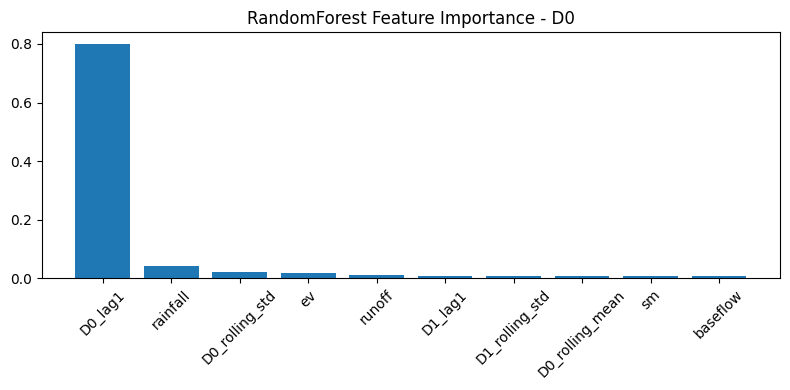


XGBoost:
MAE: 10.7220, R^2: 0.8290


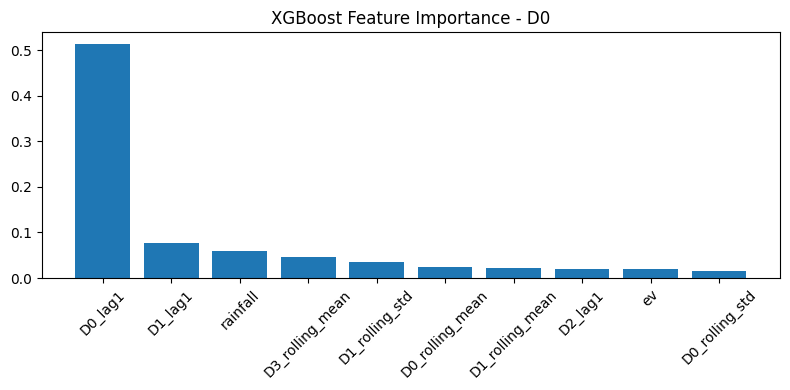


--- D1 ---

RandomForest:
MAE: 8.5406, R^2: 0.8893


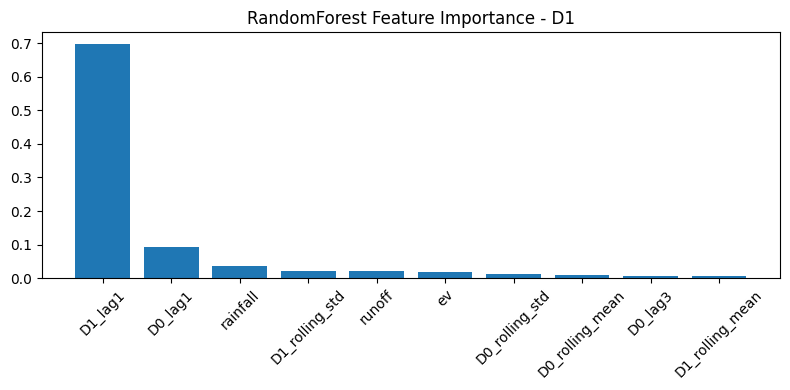


XGBoost:
MAE: 9.2435, R^2: 0.8707


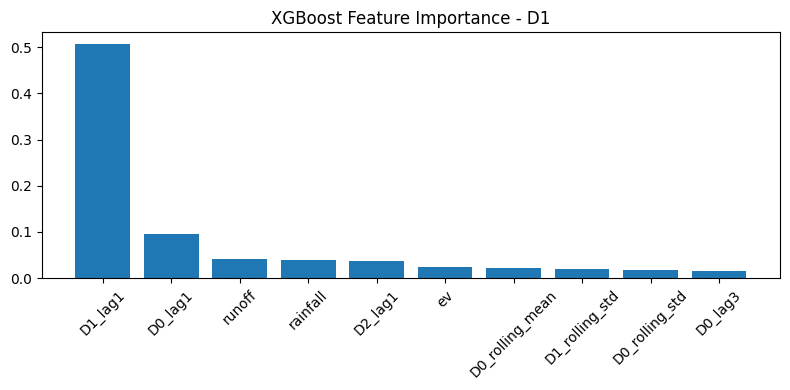


--- D2 ---

RandomForest:
MAE: 11.0344, R^2: 0.8118


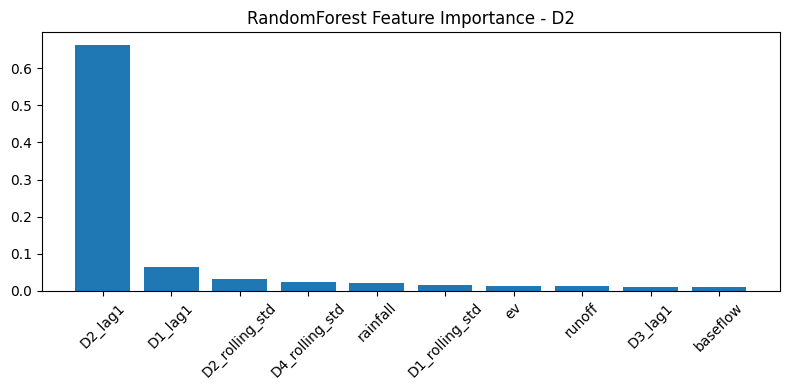


XGBoost:
MAE: 10.9151, R^2: 0.7986


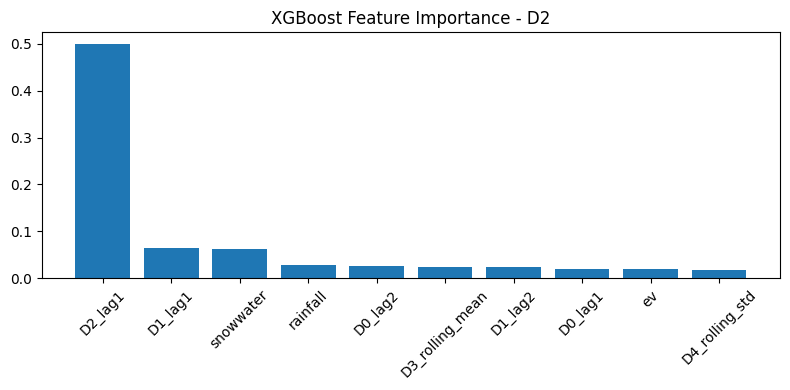


--- D3 ---

RandomForest:
MAE: 6.6332, R^2: 0.7365


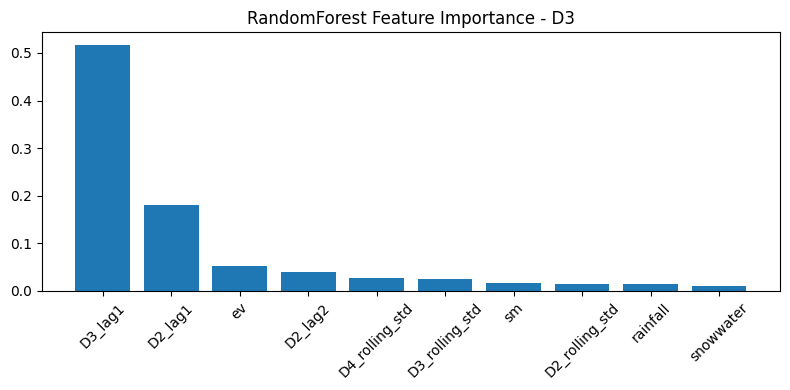


XGBoost:
MAE: 7.7224, R^2: 0.6114


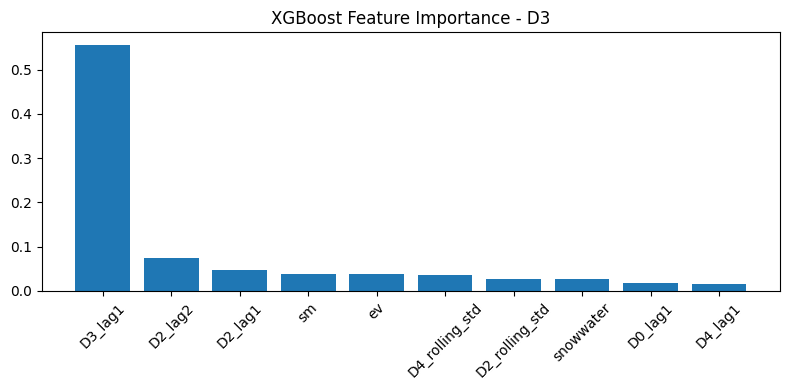


--- D4 ---

RandomForest:
MAE: 0.8117, R^2: 0.5228


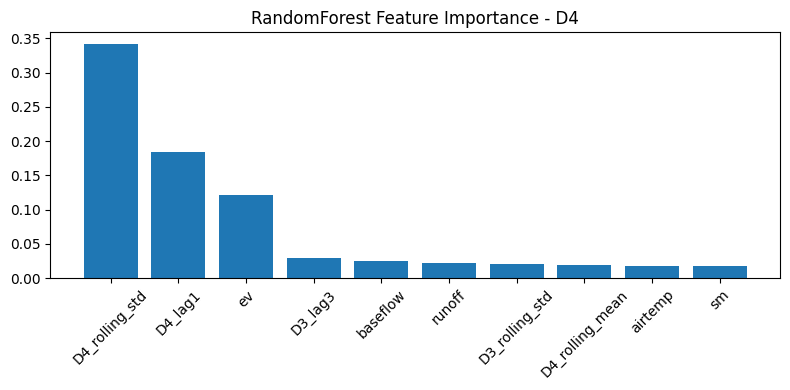


XGBoost:
MAE: 0.9300, R^2: 0.1490


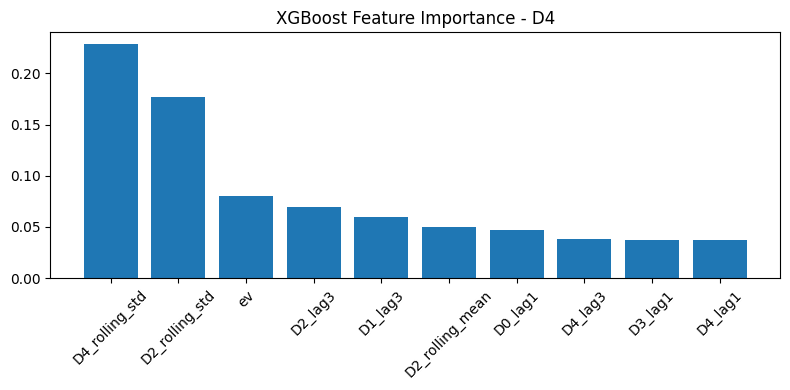

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0958 - mae: 0.1970 - val_loss: 0.1530 - val_mae: 0.2866
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0601 - mae: 0.1673 - val_loss: 0.1406 - val_mae: 0.2673
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0547 - mae: 0.1615 - val_loss: 0.1336 - val_mae: 0.2599
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0450 - mae: 0.1415 - val_loss: 0.0996 - val_mae: 0.2315
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0432 - mae: 0.1352 - val_loss: 0.0985 - val_mae: 0.2298
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0419 - mae: 0.1330 - val_loss: 0.0875 - val_mae: 0.2256
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0341 - mae: 0.1214 - val_loss: 0.0861 - val_mae: 0.2245
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0362 - mae: 0.1261 - val_loss: 0.0772 - val_mae: 0.2216
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0322 - mae: 0

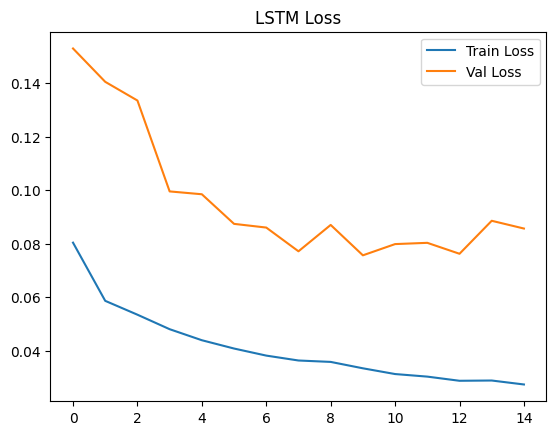

In [ ]:
# Full pipeline: Drought prediction using Random Forest, XGBoost, LSTM (with tuning) and LightGBM per drought level

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ---------- Data Preprocessing ----------
final_historical_df['date'] = pd.to_datetime(final_historical_df['date'])

# Create lag features and rolling stats
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    for lag in range(1, 4):
        final_historical_df[f'{col}_lag{lag}'] = final_historical_df[col].shift(lag)
    final_historical_df[f'{col}_rolling_mean'] = final_historical_df[col].rolling(window=7).mean()
    final_historical_df[f'{col}_rolling_std'] = final_historical_df[col].rolling(window=7).std()

final_historical_df = final_historical_df.dropna()

# Feature/target split
features = final_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
targets = final_historical_df[['D0', 'D1', 'D2', 'D3', 'D4']]

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    features, targets, test_size=0.2, shuffle=False
)

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# ---------- Random Forest & XGBoost (with Grid Search & Feature Importance) ----------
models = {
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror')
}

param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100],
        'max_depth': [5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 6]
    }
}

tscv = TimeSeriesSplit(n_splits=3)

for drought_level in ['D0', 'D1', 'D2', 'D3', 'D4']:
    print(f"\n--- {drought_level} ---")
    y_train = y_train_full[drought_level]
    y_test = y_test_full[drought_level]

    for name, model in models.items():
        print(f"\n{name}:")
        gsearch = GridSearchCV(model, param_grids[name], cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
        gsearch.fit(X_train_scaled, y_train)
        best_model = gsearch.best_estimator_

        y_pred = best_model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"MAE: {mae:.4f}, R^2: {r2:.4f}")

        importances = best_model.feature_importances_
        sorted_idx = np.argsort(importances)[::-1][:10]
        plt.figure(figsize=(8, 4))
        plt.bar(np.array(features.columns)[sorted_idx], importances[sorted_idx])
        plt.title(f'{name} Feature Importance - {drought_level}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# ---------- LSTM ----------
# We use the same preprocessing from before to create sequences
SEQ_LENGTH = 12
X_seq, y_seq = [], []

# Multivariate output for LSTM
scaled_targets = MinMaxScaler().fit_transform(y_train_full)

for i in range(len(X_train_scaled) - SEQ_LENGTH):
    X_seq.append(X_train_scaled[i:i+SEQ_LENGTH])
    y_seq.append(scaled_targets[i+SEQ_LENGTH])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

X_train_lstm, X_val_lstm = X_seq[:-100], X_seq[-100:]
y_train_lstm, y_val_lstm = y_seq[:-100], y_seq[-100:]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X_seq.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(5)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Loss')
plt.legend()
plt.show()


## Cross Validation for all models

In [50]:
print(cv_historical_df)

          date    airtemp  baseflow        ev  rainfall    runoff         sm  \
0   1950-01-01   5.469246  0.036113  0.712696  0.207599  0.011982  11.695956   
1   1950-02-01  11.261756  0.036952  0.947727  0.446101  0.028984   9.503363   
2   1950-03-01  13.522296  0.033402  0.763165  0.412884  0.010870   7.893302   
3   1950-04-01  18.837398  0.039273  0.317350  0.112882  0.007152   6.434203   
4   1950-05-01  20.676498  0.029522  0.155867  0.021634  0.000562   5.557502   
..         ...        ...       ...       ...       ...       ...        ...   
763 2013-08-01  28.717042  0.026354  0.347947  0.561113  0.008274   6.916853   
764 2013-09-01  25.199694  0.026135  0.523672  0.312458  0.004821   8.541084   
765 2013-10-01  17.191673  0.025938  0.080414  0.072593  0.001138   5.760195   
766 2013-11-01  12.775977  0.025719  0.278565  0.710123  0.015111   8.983794   
767 2013-12-01   8.067449  0.025587  0.264997  0.076278  0.001941  11.967273   

         snowfall  snowwater        D0 


--- D0 ---

Random Forest - D0 - Cross-Validation Results:
R² Mean: 0.1597, Std: 0.0657
MSE Mean: 0.1335, Std: -0.0043
MAE Mean: 0.3106, Std: -0.0082


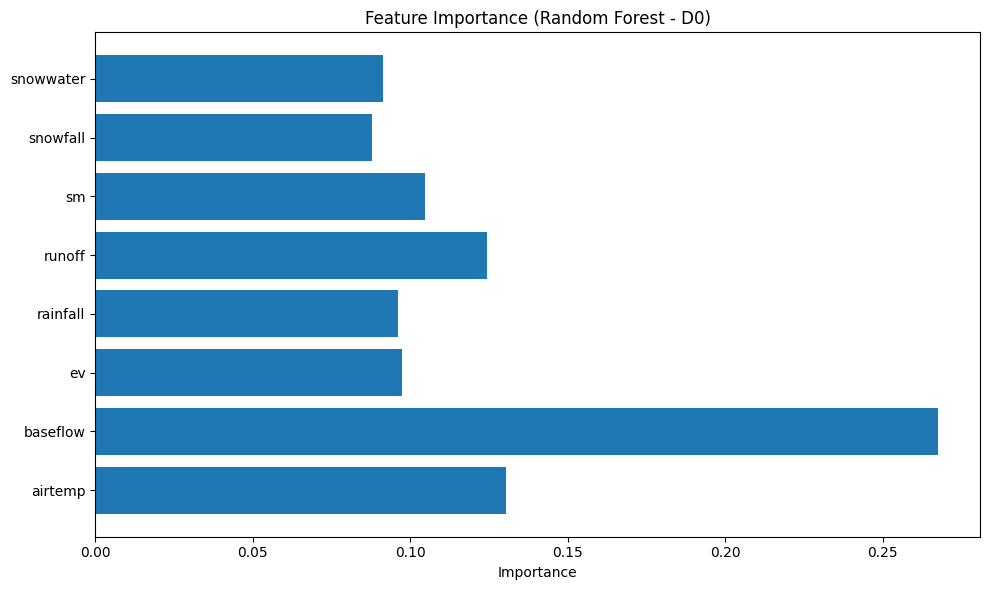


--- D1 ---

Random Forest - D1 - Cross-Validation Results:
R² Mean: 0.1155, Std: 0.0610
MSE Mean: 0.1178, Std: -0.0065
MAE Mean: 0.2838, Std: -0.0109


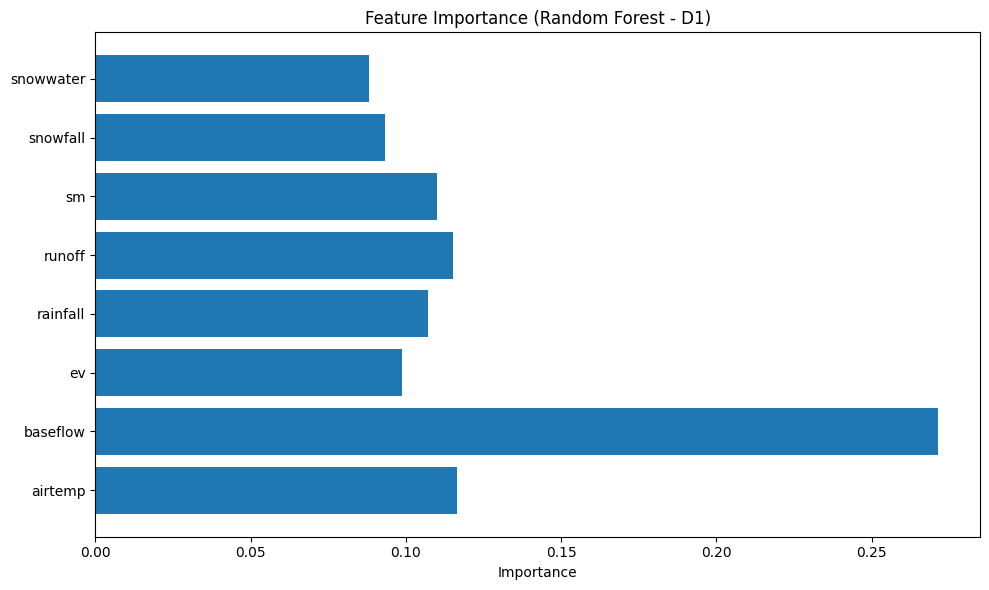


--- D2 ---

Random Forest - D2 - Cross-Validation Results:
R² Mean: 0.0776, Std: 0.0564
MSE Mean: 0.0637, Std: -0.0028
MAE Mean: 0.1837, Std: -0.0044


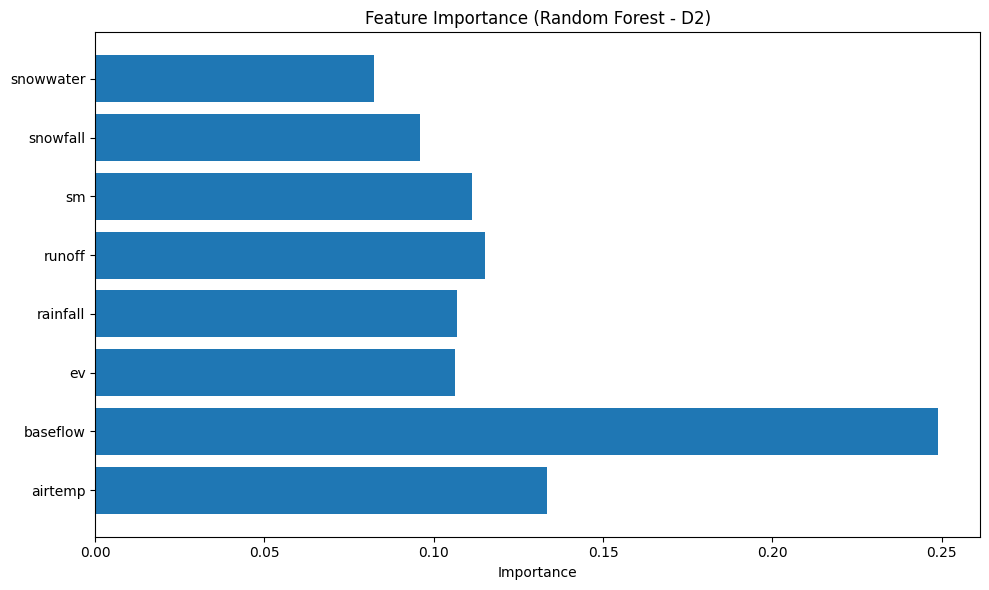


--- D3 ---

Random Forest - D3 - Cross-Validation Results:
R² Mean: -0.0119, Std: 0.1279
MSE Mean: 0.0360, Std: -0.0054
MAE Mean: 0.1073, Std: -0.0087


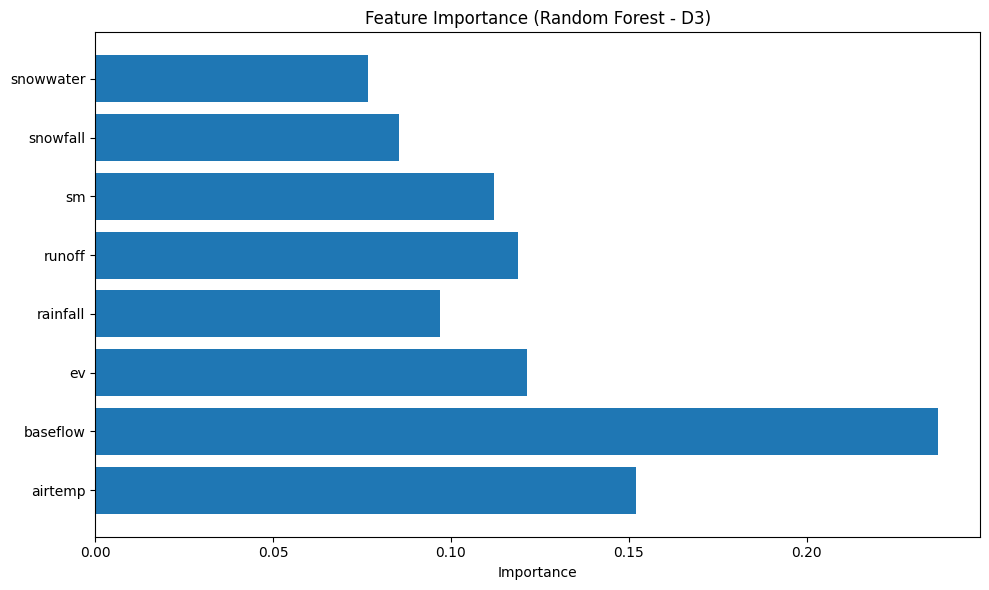


--- D4 ---

Random Forest - D4 - Cross-Validation Results:
R² Mean: -0.0490, Std: 0.1755
MSE Mean: 0.0111, Std: -0.0050
MAE Mean: 0.0428, Std: -0.0089


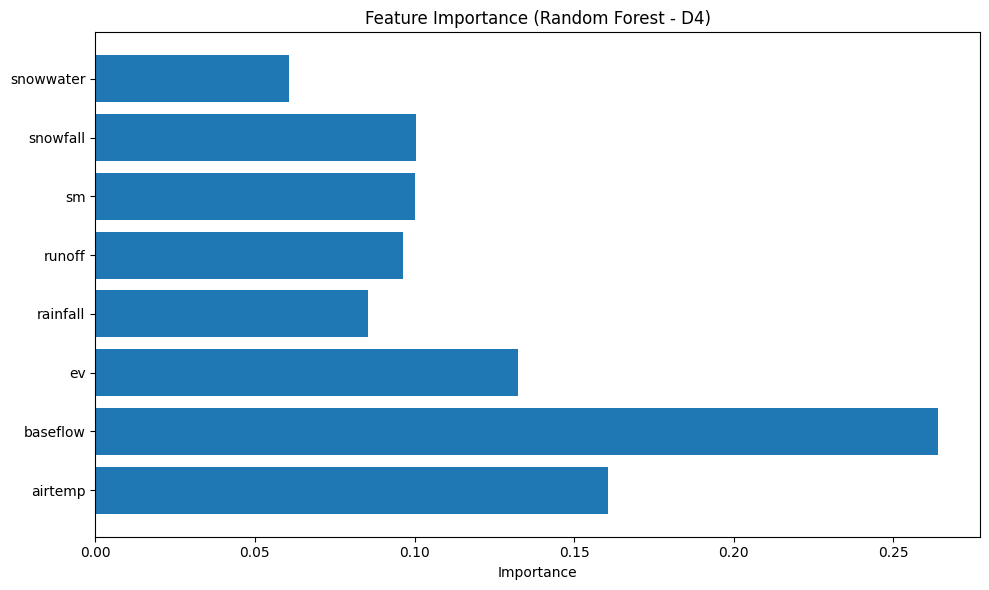


--- D0 ---

XGBoost - D0 - Cross-Validation Results:
R² Mean: 0.0562, Std: 0.1082
MSE Mean: 0.1497, Std: -0.0106
MAE Mean: 0.3152, Std: -0.0148


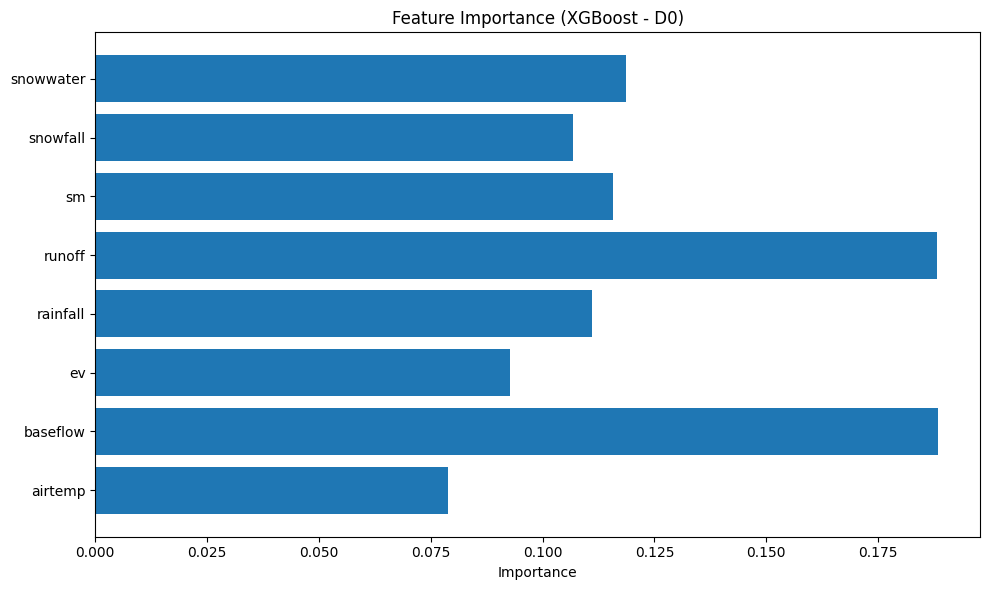


--- D1 ---

XGBoost - D1 - Cross-Validation Results:
R² Mean: -0.0320, Std: 0.0355
MSE Mean: 0.1378, Std: -0.0083
MAE Mean: 0.2973, Std: -0.0123


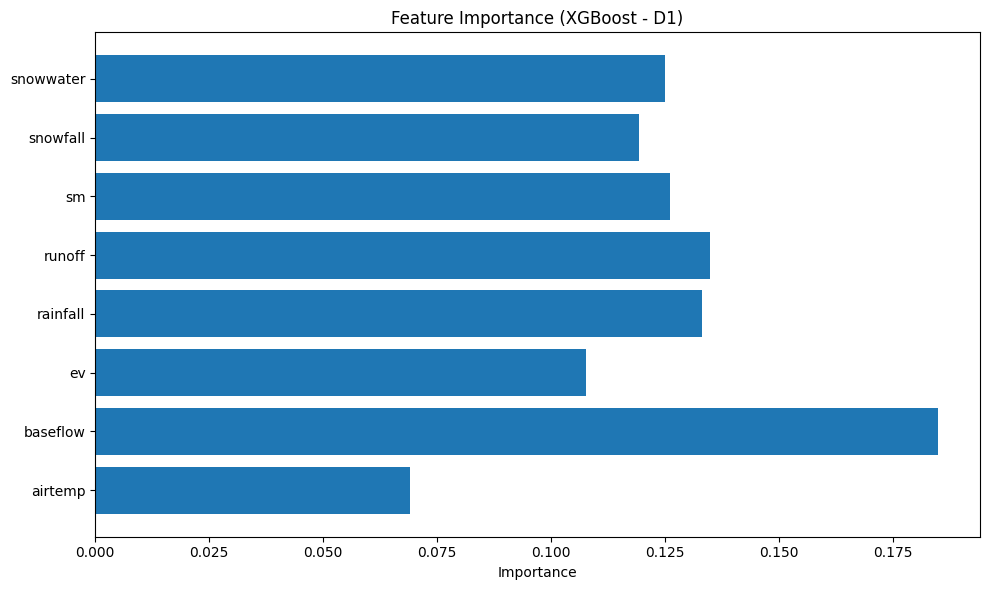


--- D2 ---

XGBoost - D2 - Cross-Validation Results:
R² Mean: -0.0346, Std: 0.0812
MSE Mean: 0.0716, Std: -0.0063
MAE Mean: 0.1913, Std: -0.0077


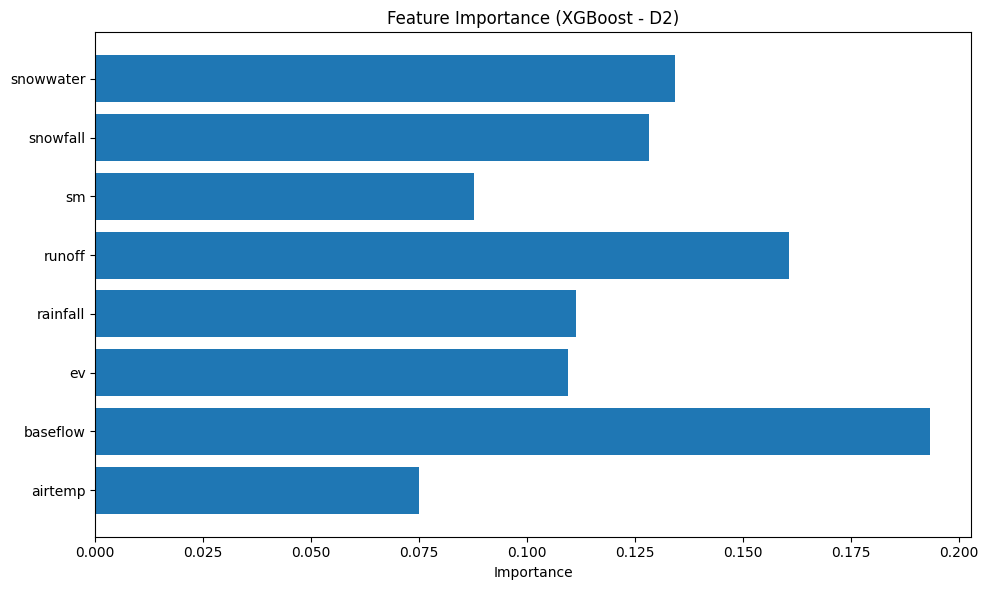


--- D3 ---

XGBoost - D3 - Cross-Validation Results:
R² Mean: -0.2469, Std: 0.2325
MSE Mean: 0.0438, Std: -0.0057
MAE Mean: 0.1174, Std: -0.0124


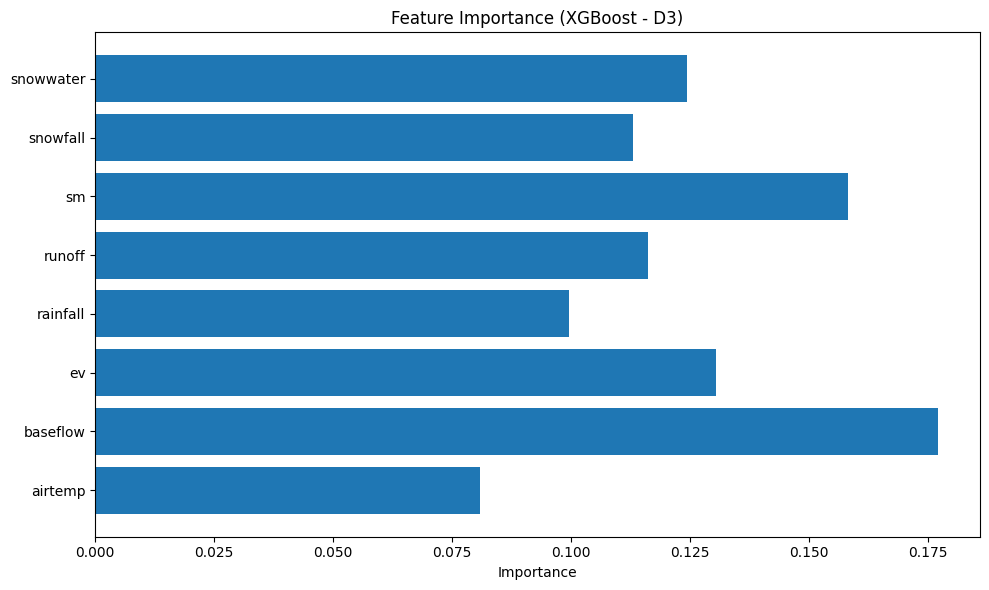


--- D4 ---

XGBoost - D4 - Cross-Validation Results:
R² Mean: -0.2401, Std: 0.3548
MSE Mean: 0.0124, Std: -0.0049
MAE Mean: 0.0442, Std: -0.0086


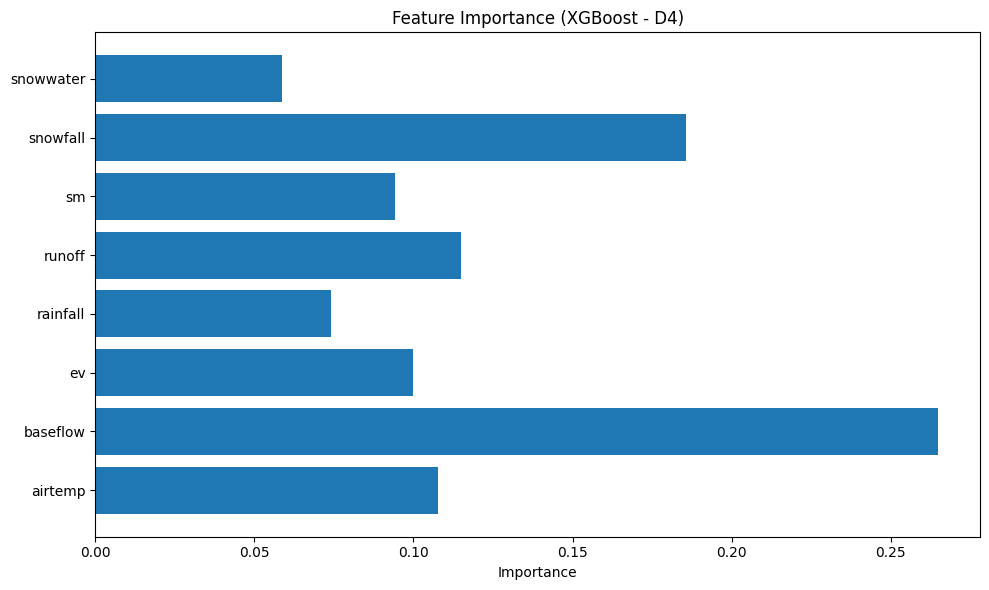

['xgb_model_all_levels.pkl']

In [104]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming final_historical_df is already preprocessed and contains features like lag and rolling stats

# Prepare the features and target variables
features = cv_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
target = cv_historical_df[['D0', 'D1', 'D2', 'D3', 'D4']]

# Normalize the features and targets
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(features)
y_scaled = target_scaler.fit_transform(target)

# Convert y_scaled to a DataFrame for easier indexing by column names
y_scaled_df = pd.DataFrame(y_scaled, columns=['D0', 'D1', 'D2', 'D3', 'D4'])

# Function to evaluate and print metrics for each model
def evaluate_model(model, X, y, label='Model'):
    # Train the model before evaluating
    model.fit(X, y)
    
    # Perform cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores_r2 = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    scores_mse = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    scores_mae = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')

    print(f"\n{label} - Cross-Validation Results:")
    print(f"R² Mean: {scores_r2.mean():.4f}, Std: {scores_r2.std():.4f}")
    print(f"MSE Mean: {-scores_mse.mean():.4f}, Std: {-scores_mse.std():.4f}")
    print(f"MAE Mean: {-scores_mae.mean():.4f}, Std: {-scores_mae.std():.4f}")

    # Plot feature importances (for Random Forest, XGBoost, LightGBM)
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    elif hasattr(model, 'get_booster'):
        feature_importances = model.get_booster().get_score(importance_type='weight')
    else:
        feature_importances = None
    
    if feature_importances is not None:
        plt.figure(figsize=(10, 6))
        if isinstance(feature_importances, np.ndarray):  # For Random Forest
            plt.barh(range(len(feature_importances)), feature_importances)
            plt.yticks(range(len(feature_importances)), features.columns)
        else:  # For XGBoost or LightGBM
            importance_scores = [feature_importances.get(f"f{i}", 0) for i in range(len(features.columns))]
            plt.barh(range(len(importance_scores)), importance_scores)
            plt.yticks(range(len(importance_scores)), features.columns)
        
        plt.title(f"Feature Importance ({label})")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation for each drought level
for drought_level in ['D0', 'D1', 'D2', 'D3', 'D4']:
    print(f"\n--- {drought_level} ---")
    y_drought = y_scaled_df[drought_level]
    evaluate_model(rf_model, X_scaled, y_drought, label=f"Random Forest - {drought_level}")

joblib.dump(rf_model, 'rf_model_all_levels.pkl')
# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

for drought_level in ['D0', 'D1', 'D2', 'D3', 'D4']:
    print(f"\n--- {drought_level} ---")
    y_drought = y_scaled_df[drought_level]
    evaluate_model(xgb_model, X_scaled, y_drought, label=f"XGBoost - {drought_level}")

joblib.dump(xgb_model, 'xgb_model_all_levels.pkl')


## Stacking Ensemble

In [52]:
print(final_historical_df.columns)

Index(['date', 'airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm',
       'snowfall', 'snowwater', 'D0', 'D1', 'D2', 'D3', 'D4', 'D0_lag1',
       'D0_lag2', 'D0_lag3', 'D1_lag1', 'D1_lag2', 'D1_lag3', 'D2_lag1',
       'D2_lag2', 'D2_lag3', 'D3_lag1', 'D3_lag2', 'D3_lag3', 'D4_lag1',
       'D4_lag2', 'D4_lag3', 'D0_rolling_mean', 'D0_rolling_std',
       'D1_rolling_mean', 'D1_rolling_std', 'D2_rolling_mean',
       'D2_rolling_std', 'D3_rolling_mean', 'D3_rolling_std',
       'D4_rolling_mean', 'D4_rolling_std'],
      dtype='object')


In [53]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# === Data Preparation ===
features = final_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
targets = final_historical_df[['D0', 'D1', 'D2', 'D3', 'D4']]

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X = pd.DataFrame(feature_scaler.fit_transform(features), columns=features.columns)
y = pd.DataFrame(target_scaler.fit_transform(targets), columns=targets.columns)

# === Sequence Creation for LSTM ===
def create_multiseq(X, y, timesteps=6):
    Xs, ys = [], []
    for i in range(timesteps, len(X)):
        Xs.append(X.iloc[i-timesteps:i].values)
        ys.append(y.iloc[i].values)
    return np.array(Xs), np.array(ys)

timesteps = 6
X_seq, y_seq = create_multiseq(X, y, timesteps)
X_tab = X.iloc[timesteps:].reset_index(drop=True)
y_tab = y.iloc[timesteps:].reset_index(drop=True)

X_tab_train, X_tab_test, y_tab_train, y_tab_test = train_test_split(X_tab, y_tab, test_size=0.2, random_state=42)
X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# === Define Models ===
base_models = {
    'RandomForest': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    'XGBoost': MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', random_state=42)),
    'SVR': MultiOutputRegressor(SVR())
}

# === Train Base Models ===
for name, model in base_models.items():
    model.fit(X_tab_train, y_tab_train)

# === LSTM Model ===
def build_lstm(input_shape, output_dim):
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(output_dim)
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

lstm_model = build_lstm((timesteps, X.shape[1]), y.shape[1])
lstm_model.fit(X_seq_train, y_seq_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)

# === Collect Predictions ===
stacked_inputs = []
for model in base_models.values():
    preds = model.predict(X_tab_test)
    stacked_inputs.append(preds)
lstm_preds = lstm_model.predict(X_seq_test)
stacked_inputs.append(lstm_preds)

stacked_inputs = np.hstack(stacked_inputs)

# === Meta-Model (Stacking) ===
meta_models = []
final_preds = []
for i in range(y.shape[1]):
    meta_input_i = stacked_inputs[:, i::y.shape[1]]
    meta_model = Ridge()
    meta_model.fit(meta_input_i, y_tab_test.iloc[:, i])
    final_preds.append(meta_model.predict(meta_input_i))
    meta_models.append(meta_model)

final_preds = np.array(final_preds).T
mae = mean_absolute_error(y_tab_test, final_preds)
print(f"\n🔮 Final Multi-Output Stacked MAE: {mae:.4f}")

# === Inverse Transform Predictions ===
final_preds_unscaled = target_scaler.inverse_transform(final_preds)
true_unscaled = target_scaler.inverse_transform(y_tab_test)

results_df = pd.DataFrame(final_preds_unscaled, columns=['D0', 'D1', 'D2', 'D3', 'D4'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

🔮 Final Multi-Output Stacked MAE: 0.0627


In [ ]:
class StackedDroughtModel:
    def __init__(self, base_models, meta_models, lstm_model, feature_scaler, target_scaler, timesteps):
        self.base_models = base_models  # Dict of sklearn models
        self.meta_models = meta_models  # List of Ridge models (1 per drought target)
        self.lstm_model = lstm_model    # Trained LSTM model
        self.feature_scaler = feature_scaler
        self.target_scaler = target_scaler
        self.timesteps = timesteps

    def preprocess(self, X_df):
        X_scaled = self.feature_scaler.transform(X_df)
        X_seq = []
        for i in range(self.timesteps, len(X_scaled) + 1):
            X_seq.append(X_scaled[i - self.timesteps:i])
        return np.array(X_scaled[self.timesteps - 1:]), np.array(X_seq)

    def predict(self, X_df):
        X_tab, X_seq = self.preprocess(X_df)
        
        # Base model predictions
        base_preds = []
        for model in self.base_models.values():
            base_preds.append(model.predict(X_tab))
        
        lstm_preds = self.lstm_model.predict(X_seq)
        stacked_input = np.hstack(base_preds + [lstm_preds])
        
        # Meta model predictions
        final_preds = []
        for i, meta_model in enumerate(self.meta_models):
            meta_input_i = stacked_input[:, i::len(self.meta_models)]
            pred = meta_model.predict(meta_input_i)
            final_preds.append(pred)
        
        final_preds = np.array(final_preds).T
        return self.target_scaler.inverse_transform(final_preds)

## Applying to predicted values from loca-vic cal-adapt model

Step 1. Load data

Warm/Dry RCP 85

In [55]:
# load loca-vic rcp 8.5 data for all variables
# sample folder name that has projected values: projected_baseflow_2006_2099_monthly
# sample file name: tair_month_HadGEM2-ES_rcp85.csv

model = "HadGEM2-ES"
emissions = "rcp85"
monthlydf_names = ["airtemp", "baseflow", "ev", "rainfall", "runoff", "snowfall", "snowwater", "sm"]

monthly2099_df = {}
for t in monthlydf_names:
    new_df = pd.read_csv(path + f'/data/projected_{t}_2006_2099_monthly/{t}_month_{model}_{emissions}.csv')
    column = new_df.columns[1]
    new_df.rename(columns={column: t}, inplace=True)

    new_df.rename(columns={'time': 'date'}, inplace=True)
    
    # convert date column to datetime format
    new_df['date'] = pd.to_datetime(new_df['date'])
    
    # filter data from 2014 to 2024
    new_df = new_df[(new_df['date'].dt.year >= 2025)]
    
    # format the datetime objects to 'yyyy-mm'
    new_df['date'] = new_df['date'].dt.strftime('%Y-%m')

    monthly2099_df[f"monthly_{t}2099"] = new_df

monthly_airtemp2099 = monthly2099_df['monthly_airtemp2099']
monthly_baseflow2099 = monthly2099_df['monthly_baseflow2099']
monthly_ev2099 = monthly2099_df['monthly_ev2099']
monthly_rainfall2099 = monthly2099_df['monthly_rainfall2099']
monthly_runoff2099 = monthly2099_df['monthly_runoff2099']
monthly_sm2099 = monthly2099_df['monthly_sm2099']
monthly_snowfall2099 = monthly2099_df['monthly_snowfall2099']
monthly_snowwater2099 = monthly2099_df['monthly_snowwater2099']

In [56]:
# merge all variables together into dataframe
dfs = [monthly_airtemp2099, monthly_baseflow2099, monthly_ev2099, monthly_rainfall2099, monthly_runoff2099, monthly_sm2099, monthly_snowfall2099, monthly_snowwater2099]
future_all_df = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
print(future_all_df)

        date    airtemp  baseflow        ev  rainfall    runoff         sm  \
0    2025-01   9.803126  0.084312  0.622300  1.418613  0.079518  17.105133   
1    2025-02  12.278653  0.061697  0.634722  0.017109  0.002295  11.057837   
2    2025-03  14.580974  0.049073  0.726777  0.397974  0.012798   9.526969   
3    2025-04  20.532830  0.037250  0.368183  0.069846  0.001874   5.987801   
4    2025-05  23.983065  0.031096  0.231947  0.105228  0.002222   5.783203   
..       ...        ...       ...       ...       ...       ...        ...   
895  2099-08  34.251865  0.023483  0.320119  0.359717  0.007285   7.520611   
896  2099-09  31.394010  0.023069  0.337229  0.379172  0.007210   7.411820   
897  2099-10  25.734106  0.022785  0.121622  0.050756  0.000660   6.161460   
898  2099-11  19.936472  0.022535  0.057377  0.059304  0.000669   5.606383   
899  2099-12  15.639469  0.022299  0.021902  0.011081  0.000182   5.602591   

     snowfall  snowwater  
0    0.053516   0.984353  
1    0.00

In [147]:
future_all_df.to_csv('future_all_df_wd_85.csv')

Warm and Dry RCP 45

In [178]:
# load loca-vic rcp 4.5 data for all variables
# sample folder name that has projected values: projected_baseflow_2006_2099_monthly
# sample file name: tair_month_HadGEM2-ES_rcp85.csv

model = "HadGEM2-ES"
emissions = "rcp45"
monthlydf_names = ["airtemp", "baseflow", "ev", "rainfall", "runoff", "snowfall", "snowwater", "sm"]

monthly2099_df = {}
for t in monthlydf_names:
    new_df = pd.read_csv(path + f'/data/projected_{t}_2006_2099_monthly/{t}_month_{model}_{emissions}.csv')
    column = new_df.columns[1]
    new_df.rename(columns={column: t}, inplace=True)

    new_df.rename(columns={'time': 'date'}, inplace=True)
    
    # convert date column to datetime format
    new_df['date'] = pd.to_datetime(new_df['date'])
    
    # filter data from 2014 to 2024
    new_df = new_df[(new_df['date'].dt.year >= 2025)]
    
    # format the datetime objects to 'yyyy-mm'
    new_df['date'] = new_df['date'].dt.strftime('%Y-%m')

    monthly2099_df[f"monthly_{t}2099"] = new_df

monthly_airtemp2099 = monthly2099_df['monthly_airtemp2099']
monthly_baseflow2099 = monthly2099_df['monthly_baseflow2099']
monthly_ev2099 = monthly2099_df['monthly_ev2099']
monthly_rainfall2099 = monthly2099_df['monthly_rainfall2099']
monthly_runoff2099 = monthly2099_df['monthly_runoff2099']
monthly_sm2099 = monthly2099_df['monthly_sm2099']
monthly_snowfall2099 = monthly2099_df['monthly_snowfall2099']
monthly_snowwater2099 = monthly2099_df['monthly_snowwater2099']

In [164]:
# merge all variables together into dataframe
dfs = [monthly_airtemp2099, monthly_baseflow2099, monthly_ev2099, monthly_rainfall2099, monthly_runoff2099, monthly_sm2099, monthly_snowfall2099, monthly_snowwater2099]
future_all_df_wd45 = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
print(future_all_df_wd45)

        date    airtemp  baseflow        ev  rainfall    runoff         sm  \
0    2025-01  10.844298  0.055284  0.659478  1.136183  0.061125  16.697283   
1    2025-02   9.943104  0.179933  0.972214  2.677946  0.200177  18.577960   
2    2025-03  13.433353  0.257004  1.264626  0.513908  0.056562  15.340068   
3    2025-04  19.796211  0.076995  0.814993  0.061032  0.010495   6.492800   
4    2025-05  21.039589  0.038936  0.395360  0.189511  0.004812   6.238356   
..       ...        ...       ...       ...       ...       ...        ...   
895  2099-08  29.713646  0.018928  0.213591  0.264611  0.004904   6.647458   
896  2099-09  27.577723  0.018706  0.105358  0.026814  0.000271   5.948973   
897  2099-10  23.679895  0.018549  0.341856  0.362800  0.004847   7.173334   
898  2099-11  18.096601  0.018406  0.265125  0.481206  0.007422   6.866368   
899  2099-12  10.102968  0.019794  0.443332  0.683295  0.020650  13.422372   

     snowfall  snowwater  
0    0.040357   0.610072  
1    0.19

In [165]:
future_all_df_wd45.to_csv('future_all_df_wd_45.csv')

Wet and Cool RCP 85

In [166]:
# load loca-vic rcp 8.5 data for all variables
# sample folder name that has projected values: projected_baseflow_2006_2099_monthly
# sample file name: tair_month_HadGEM2-ES_rcp85.csv

model = "CNRM-CM5"
emissions = "rcp85"
monthlydf_names = ["airtemp", "baseflow", "ev", "rainfall", "runoff", "snowfall", "snowwater", "sm"]

monthly2099_df = {}
for t in monthlydf_names:
    new_df = pd.read_csv(path + f'/data/projected_{t}_2006_2099_monthly/{t}_month_{model}_{emissions}.csv')
    column = new_df.columns[1]
    new_df.rename(columns={column: t}, inplace=True)

    new_df.rename(columns={'time': 'date'}, inplace=True)
    
    # convert date column to datetime format
    new_df['date'] = pd.to_datetime(new_df['date'])
    
    # filter data from 2014 to 2024
    new_df = new_df[(new_df['date'].dt.year >= 2025)]
    
    # format the datetime objects to 'yyyy-mm'
    new_df['date'] = new_df['date'].dt.strftime('%Y-%m')

    monthly2099_df[f"monthly_{t}2099"] = new_df

monthly_airtemp2099 = monthly2099_df['monthly_airtemp2099']
monthly_baseflow2099 = monthly2099_df['monthly_baseflow2099']
monthly_ev2099 = monthly2099_df['monthly_ev2099']
monthly_rainfall2099 = monthly2099_df['monthly_rainfall2099']
monthly_runoff2099 = monthly2099_df['monthly_runoff2099']
monthly_sm2099 = monthly2099_df['monthly_sm2099']
monthly_snowfall2099 = monthly2099_df['monthly_snowfall2099']
monthly_snowwater2099 = monthly2099_df['monthly_snowwater2099']

In [167]:
# merge all variables together into dataframe
dfs = [monthly_airtemp2099, monthly_baseflow2099, monthly_ev2099, monthly_rainfall2099, monthly_runoff2099, monthly_sm2099, monthly_snowfall2099, monthly_snowwater2099]
future_all_df_avg85 = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
print(future_all_df_avg85)

        date    airtemp  baseflow        ev  rainfall    runoff         sm  \
0    2025-01  10.207773  0.032139  0.362057  1.004271  0.039846  12.075030   
1    2025-02  13.984876  0.034246  0.450719  0.083174  0.006275  10.573587   
2    2025-03  15.723686  0.034421  0.481389  0.472676  0.015048   8.120767   
3    2025-04  16.983013  0.034586  0.373516  0.241494  0.005192   7.043604   
4    2025-05  22.606312  0.031917  0.168676  0.041392  0.000955   5.708486   
..       ...        ...       ...       ...       ...       ...        ...   
895  2099-08  33.989147  0.034880  0.628838  1.138368  0.035685   8.491336   
896  2099-09  30.976736  0.035401  0.479314  0.063888  0.000720   8.256879   
897  2099-10  24.394602  0.034316  0.096049  0.058819  0.000903   5.932549   
898  2099-11  18.994652  0.033833  0.017242  0.006377  0.000070   5.426496   
899  2099-12  16.167698  0.033457  0.071248  0.137669  0.002129   5.791756   

     snowfall     snowwater  
0    0.056763  6.751617e-01  
1  

In [ ]:
future_all_df_avg85.to_csv('future_all_df_avg_85.csv')

Wet and Cool RCP 45

In [ ]:
# load loca-vic rcp 4.5 data for all variables
# sample folder name that has projected values: projected_baseflow_2006_2099_monthly
# sample file name: tair_month_HadGEM2-ES_rcp85.csv

model = "CNRM-CM5"
emissions = "rcp45"
monthlydf_names = ["airtemp", "baseflow", "ev", "rainfall", "runoff", "snowfall", "snowwater", "sm"]

monthly2099_df = {}
for t in monthlydf_names:
    new_df = pd.read_csv(path + f'/data/projected_{t}_2006_2099_monthly/{t}_month_{model}_{emissions}.csv')
    column = new_df.columns[1]
    new_df.rename(columns={column: t}, inplace=True)

    new_df.rename(columns={'time': 'date'}, inplace=True)
    
    # convert date column to datetime format
    new_df['date'] = pd.to_datetime(new_df['date'])
    
    # filter data from 2014 to 2024
    new_df = new_df[(new_df['date'].dt.year >= 2025)]
    
    # format the datetime objects to 'yyyy-mm'
    new_df['date'] = new_df['date'].dt.strftime('%Y-%m')

    monthly2099_df[f"monthly_{t}2099"] = new_df

monthly_airtemp2099 = monthly2099_df['monthly_airtemp2099']
monthly_baseflow2099 = monthly2099_df['monthly_baseflow2099']
monthly_ev2099 = monthly2099_df['monthly_ev2099']
monthly_rainfall2099 = monthly2099_df['monthly_rainfall2099']
monthly_runoff2099 = monthly2099_df['monthly_runoff2099']
monthly_sm2099 = monthly2099_df['monthly_sm2099']
monthly_snowfall2099 = monthly2099_df['monthly_snowfall2099']
monthly_snowwater2099 = monthly2099_df['monthly_snowwater2099']

# merge all variables together into dataframe
dfs = [monthly_airtemp2099, monthly_baseflow2099, monthly_ev2099, monthly_rainfall2099, monthly_runoff2099, monthly_sm2099, monthly_snowfall2099, monthly_snowwater2099]
future_all_df_avg45 = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
print(future_all_df_avg45)

future_all_df_avg45.to_csv('future_all_df_avg_45.csv')

        date    airtemp  baseflow        ev  rainfall    runoff         sm  \
0    2025-01   9.038892  0.031028  0.344615  0.466812  0.013208  10.572088   
1    2025-02  10.212016  0.268882  1.331007  5.550519  0.534314  21.616426   
2    2025-03  12.446793  0.293419  1.238334  0.092177  0.043721  13.503283   
3    2025-04  17.979520  0.129436  1.111957  0.404141  0.040263   6.982250   
4    2025-05  22.603802  0.074508  0.595422  0.108274  0.011228   6.866168   
..       ...        ...       ...       ...       ...       ...        ...   
895  2099-08  31.672953  0.029380  0.360096  0.556501  0.008958   6.675127   
896  2099-09  29.126562  0.034709  1.595504  1.986249  0.061377  14.386288   
897  2099-10  22.615654  0.036880  0.819373  0.871778  0.023999  10.483356   
898  2099-11  16.507563  0.035827  0.267082  0.052497  0.000979   8.440783   
899  2099-12  11.713230  0.032668  0.204827  0.411771  0.008917   7.549418   

     snowfall  snowwater  
0    0.025135   0.235168  
1    0.36

Average Climate RCP 45

In [175]:
# load loca-vic rcp 8.5 data for all variables
# sample folder name that has projected values: projected_baseflow_2006_2099_monthly
# sample file name: tair_month_HadGEM2-ES_rcp85.csv

model = "CanESM2"
emissions = "rcp45"
monthlydf_names = ["airtemp", "baseflow", "ev", "rainfall", "runoff", "snowfall", "snowwater", "sm"]

monthly2099_df = {}
for t in monthlydf_names:
    new_df = pd.read_csv(path + f'/data/projected_{t}_2006_2099_monthly/{t}_month_{model}_{emissions}.csv')
    column = new_df.columns[1]
    new_df.rename(columns={column: t}, inplace=True)

    new_df.rename(columns={'time': 'date'}, inplace=True)
    
    # convert date column to datetime format
    new_df['date'] = pd.to_datetime(new_df['date'])
    
    # filter data from 2014 to 2024
    new_df = new_df[(new_df['date'].dt.year >= 2025)]
    
    # format the datetime objects to 'yyyy-mm'
    new_df['date'] = new_df['date'].dt.strftime('%Y-%m')

    monthly2099_df[f"monthly_{t}2099"] = new_df

monthly_airtemp2099 = monthly2099_df['monthly_airtemp2099']
monthly_baseflow2099 = monthly2099_df['monthly_baseflow2099']
monthly_ev2099 = monthly2099_df['monthly_ev2099']
monthly_rainfall2099 = monthly2099_df['monthly_rainfall2099']
monthly_runoff2099 = monthly2099_df['monthly_runoff2099']
monthly_sm2099 = monthly2099_df['monthly_sm2099']
monthly_snowfall2099 = monthly2099_df['monthly_snowfall2099']
monthly_snowwater2099 = monthly2099_df['monthly_snowwater2099']

# merge all variables together into dataframe
dfs = [monthly_airtemp2099, monthly_baseflow2099, monthly_ev2099, monthly_rainfall2099, monthly_runoff2099, monthly_sm2099, monthly_snowfall2099, monthly_snowwater2099]
future_all_df_avg45 = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
print(future_all_df_avg45)

future_all_df_avg45.to_csv('future_all_df_wc_45.csv')

        date    airtemp  baseflow        ev  rainfall    runoff         sm  \
0    2025-01   9.860998  0.025506  0.094955  0.127691  0.003558   7.094812   
1    2025-02  11.073206  0.029322  0.741300  1.059043  0.037187  13.196322   
2    2025-03  16.292000  0.028188  0.402255  0.118929  0.003240   7.541194   
3    2025-04  20.230106  0.026403  0.127998  0.015245  0.000297   5.666104   
4    2025-05  24.666279  0.025396  0.036865  0.000942  0.000011   5.322455   
..       ...        ...       ...       ...       ...       ...        ...   
895  2099-08  33.851818  0.025561  0.442377  0.495766  0.009254   8.447068   
896  2099-09  29.189394  0.025344  0.453592  0.356981  0.006993   8.070059   
897  2099-10  23.404432  0.025125  0.024801  0.005892  0.000055   5.413778   
898  2099-11  17.180922  0.024894  0.031678  0.035581  0.000472   5.491461   
899  2099-12  12.486073  0.024666  0.031687  0.021803  0.000205   5.518375   

         snowfall     snowwater  
0    1.048683e-02  1.332124e-

Average Climate RCP 85

In [176]:
# load loca-vic rcp 8.5 data for all variables
# sample folder name that has projected values: projected_baseflow_2006_2099_monthly
# sample file name: tair_month_HadGEM2-ES_rcp85.csv

model = "CanESM2"
emissions = "rcp85"
monthlydf_names = ["airtemp", "baseflow", "ev", "rainfall", "runoff", "snowfall", "snowwater", "sm"]

monthly2099_df = {}
for t in monthlydf_names:
    new_df = pd.read_csv(path + f'/data/projected_{t}_2006_2099_monthly/{t}_month_{model}_{emissions}.csv')
    column = new_df.columns[1]
    new_df.rename(columns={column: t}, inplace=True)

    new_df.rename(columns={'time': 'date'}, inplace=True)
    
    # convert date column to datetime format
    new_df['date'] = pd.to_datetime(new_df['date'])
    
    # filter data from 2014 to 2024
    new_df = new_df[(new_df['date'].dt.year >= 2025)]
    
    # format the datetime objects to 'yyyy-mm'
    new_df['date'] = new_df['date'].dt.strftime('%Y-%m')

    monthly2099_df[f"monthly_{t}2099"] = new_df

monthly_airtemp2099 = monthly2099_df['monthly_airtemp2099']
monthly_baseflow2099 = monthly2099_df['monthly_baseflow2099']
monthly_ev2099 = monthly2099_df['monthly_ev2099']
monthly_rainfall2099 = monthly2099_df['monthly_rainfall2099']
monthly_runoff2099 = monthly2099_df['monthly_runoff2099']
monthly_sm2099 = monthly2099_df['monthly_sm2099']
monthly_snowfall2099 = monthly2099_df['monthly_snowfall2099']
monthly_snowwater2099 = monthly2099_df['monthly_snowwater2099']

# merge all variables together into dataframe
dfs = [monthly_airtemp2099, monthly_baseflow2099, monthly_ev2099, monthly_rainfall2099, monthly_runoff2099, monthly_sm2099, monthly_snowfall2099, monthly_snowwater2099]
future_all_df_avg45 = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
print(future_all_df_avg45)

future_all_df_avg45.to_csv('future_all_df_wc_85.csv')

        date    airtemp  baseflow        ev  rainfall    runoff         sm  \
0    2025-01   7.707412  0.080191  0.770596  2.919712  0.293058  18.754398   
1    2025-02   9.683879  0.095787  0.833516  0.984980  0.052695  15.888376   
2    2025-03  13.580926  0.374438  1.621244  3.161903  0.329782  19.826640   
3    2025-04  16.272213  0.223424  1.626187  0.400497  0.047949  12.503349   
4    2025-05  23.343159  0.087249  0.676284  0.001555  0.032563   5.956820   
..       ...        ...       ...       ...       ...       ...        ...   
895  2099-08  36.738350  0.040917  0.615501  0.681485  0.016602  10.198376   
896  2099-09  31.665892  0.041302  0.540507  0.248570  0.004697   9.261426   
897  2099-10  23.322968  0.039406  0.241418  0.231988  0.003614   6.846445   
898  2099-11  18.393840  0.038102  0.104193  0.103611  0.001266   6.009923   
899  2099-12  13.543053  0.037574  0.406019  0.837350  0.020836   9.643585   

     snowfall     snowwater  
0    0.346777  6.842435e+00  
1  

Step 2. Data pre-processing and formatting to do recursive predictions

In [57]:
# Step 1: Preprocessing and Feature Engineering

# for rgb, xgb, svr
base_features = ["airtemp", "baseflow", "ev", "rainfall", "runoff", "snowfall", "snowwater", "sm"]

# last 7 months
history_d0d4 = final_historical_df[-7:]
history_d0d4 = history_d0d4[['date', 'D0', 'D1', 'D2', 'D3', 'D4']].reset_index(drop=True)
print(history_d0d4)

        date       D0      D1       D2    D3   D4
0 2024-06-01   6.7825   0.000   0.0000  0.00  0.0
1 2024-07-01   6.6720   0.000   0.0000  0.00  0.0
2 2024-08-01  25.2900   0.000   0.0000  0.00  0.0
3 2024-09-01  70.2500  46.765   0.4575  0.00  0.0
4 2024-10-01  73.0220  48.726   9.8120  0.00  0.0
5 2024-11-01  73.6150  52.335  19.0125  2.95  0.0
6 2024-12-01  94.7060  62.130  21.6700  4.36  0.0


Recursive monthly prediction with a window of at most 7 months

In [61]:
def recursive_monthly_prediction(df_future, history_df, stacked_model):
    """
    Predicts D0–D4 levels month by month using recursive prediction,
    with lag and rolling features derived from prior predicted values.

    Parameters:
    - df_future: DataFrame with monthly environmental features and 'date' column (no D0–D4)
    - history_df: DataFrame with last 7 months of actual D0–D4 values and 'date' column
    - stacked_model: Trained stacked ensemble model with predict method

    Returns:
    - DataFrame with monthly predictions for D0–D4 from df_future
    """
    df_future = df_future.copy()
    print(df_future)
    history = history_df.copy()
    history['date'] = pd.to_datetime(history['date'])
    df_future['date'] = pd.to_datetime(df_future['date'])

    print("history before add \n", history)

    predictions = []
    expected_columns = feature_scaler.feature_names_in_
    print(expected_columns)

    for idx, row in df_future.iterrows():
        current = row.copy()
        current_df = pd.DataFrame([current])

        for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
            if col not in current_df.columns:
                current_df[col] = np.nan

        print("current_df \n", current_df)
        print("history \n", history)

        if len(history) < 7:
            print("Not enough history to compute rolling stats. Skipping.")
            continue

        # --- Compute lag and rolling features based ONLY on history ---
        for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
            for lag in range(1, 4):
                shifted = history[col].shift(lag)
                if shifted.notna().any():
                    current_df[f'{col}_lag{lag}'] = shifted.iloc[-1]
                else:
                    current_df[f'{col}_lag{lag}'] = 0  # or np.nan if you prefer
            
            rolling_mean = history[col].rolling(window=7).mean()
            rolling_std = history[col].rolling(window=7).std()

            # Assign last available rolling mean/std to current
            if not rolling_mean.isna().all():
                current_df[f'{col}_rolling_mean'] = rolling_mean.iloc[-1]
            else:
                current_df[f'{col}_rolling_mean'] = 0

            if not rolling_std.isna().all():
                current_df[f'{col}_rolling_std'] = rolling_std.iloc[-1]
            else:
                current_df[f'{col}_rolling_std'] = 0

            print(f"Features for {col}:")
            print(current_df[[f'{col}_lag1', f'{col}_lag2', f'{col}_lag3', f'{col}_rolling_mean', f'{col}_rolling_std']])
        
        # print(current_df)

    #     # --- Predict based on the updated current_df ---
    #     # Remove the original D0-D4 columns from current_df
    #     current_df = current_df.drop(columns=['D0', 'D1', 'D2', 'D3', 'D4'])

    #     # Ensure the columns are in the same order as expected by the model
    #     expected_columns = ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater',
    #                         'D0_lag1', 'D0_lag2', 'D0_lag3', 'D1_lag1', 'D1_lag2', 'D1_lag3', 'D2_lag1',
    #                         'D2_lag2', 'D2_lag3', 'D3_lag1', 'D3_lag2', 'D3_lag3', 'D4_lag1', 'D4_lag2',
    #                         'D4_lag3', 'D0_rolling_mean', 'D0_rolling_std', 'D1_rolling_mean', 'D1_rolling_std',
    #                         'D2_rolling_mean', 'D2_rolling_std', 'D3_rolling_mean', 'D3_rolling_std',
    #                         'D4_rolling_mean', 'D4_rolling_std']

    #     # Reorder the columns to match the expected structure
    #     current_df = current_df[expected_columns]

    #     preds = stacked_model.predict(current_df)

    #     # Fill predictions into current_df
    #     current_df[['D0', 'D1', 'D2', 'D3', 'D4']] = preds

    #     # Save prediction
    #     predictions.append(current_df[['date', 'D0', 'D1', 'D2', 'D3', 'D4']])

    #     # Update history with the newly predicted current month
    #     history = pd.concat([history, current_df[['date', 'D0', 'D1', 'D2', 'D3', 'D4']]], ignore_index=True)
    #     history = history.sort_values("date").reset_index(drop=True)

    # # Combine all predictions into final DataFrame
    # result_df = pd.concat(predictions, ignore_index=True)
    # return result_df


        # Ensure non-D0 columns are not NaN
        for col in ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater']:
            if current_df[col].isna().any():
                print(f"Warning: NaN values found in column {col} at idx {idx}")
                current_df[col].fillna(0, inplace=True)  # Replace NaNs with 0, or use 'ffill' if appropriate

        # Get the latest complete row for prediction
        model_input = current_df.iloc[-1:]

        # Drop non-feature columns and reorder features to match training order
        input_features = model_input.drop(columns=['date'] + ['D0', 'D1', 'D2', 'D3', 'D4'])

        # Ensure rolling features are included and in the right order
        input_features = input_features[expected_columns]

        # Check the shape and columns of the input before scaling
        print(f"input_features before scaling for idx {idx}:")
        print(input_features.head(), "\n")

        # Scale the features using the same scaler used for training
        try:
            input_scaled = feature_scaler.transform(input_features)
        except ValueError as e:
            print(f"Error scaling input for idx {idx}: {e}")
            continue

        # Predict D0–D4
        try:
            pred = stacked_model.predict(input_scaled)[0]
        except Exception as e:
            print(f"Prediction error for idx {idx}: {e}")
            continue

        # Add predicted D0–D4 to the current row
        for i, d in enumerate(['D0', 'D1', 'D2', 'D3', 'D4']):
            current[d] = pred[i]

        # Append prediction and update history
        predictions.append(current)
        history = pd.concat([history, pd.DataFrame([current])]).iloc[-7:]

    # After the loop, print final predictions
    print(f"Total predictions made: {len(predictions)}")

    return pd.DataFrame(predictions)


Making the stacked model

In [ ]:
# Instantiate the stacked model after training
stacked_model = StackedDroughtModel(
    base_models=base_models,
    meta_models=meta_models,
    lstm_model=lstm_model,
    feature_scaler=feature_scaler,
    target_scaler=target_scaler,
    timesteps=timesteps
)

# Predict D0–D4 from 2025 to 2099
predicted_d_levels = recursive_monthly_prediction(future_all_df, history_d0d4, stacked_model)

# Check result
# print(predicted_d_levels.head())

2025-01
    airtemp  baseflow      ev  rainfall    runoff         sm  snowfall  \
0  9.803126  0.084312  0.6223  1.418613  0.079518  17.105133  0.053516   

   snowwater  D0_lag1  D1_lag1  ...  D0_roll7_mean  D0_roll7_std  \
0   0.984353   73.615   52.335  ...      50.048214     36.175511   

   D1_roll7_mean  D1_roll7_std  D2_roll7_mean  D2_roll7_std  D3_roll7_mean  \
0      29.993714     28.469039       7.278857      9.632206       1.044286   

   D3_roll7_std  D4_roll7_mean  D4_roll7_std  
0      1.829316            0.0           0.0  

[1 rows x 33 columns]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


ValueError: X has 33 features, but MinMaxScaler is expecting 8 features as input.

# TreeFFuser Model

Trying out the TreeFFuser Model as Nicolas recommended from https://github.com/blei-lab/treeffuser

In [118]:
!pip install treeffuser

In [121]:
from treeffuser import Treeffuser

[DID NOT USE] Subset the historical data until 2013 to only train with data until then. 

In [151]:
drought_df_historical = drought_df.copy()

# convert date column to datetime format
drought_df_historical['date'] = pd.to_datetime(drought_df_historical['date'])

# filter data from 1950-2013
drought_df_historical = drought_df_historical[(drought_df_historical['date'].dt.year < 2014)]

print(drought_df_historical)
print(cv_historical_df.tail())


          date        D0       D1     D2       D3    D4
0   1950-01-01   90.1000  83.9000  57.90  40.8000  16.1
1   1950-02-01   92.7000  89.4000  72.40  50.8000  13.1
2   1950-03-01   95.8000  90.4000  68.80  48.5000   8.3
3   1950-04-01   96.1000  90.9000  70.60  43.6000   0.2
4   1950-05-01   97.5000  90.8000  76.80  29.2000   0.1
..         ...       ...      ...    ...      ...   ...
763 2013-08-01  100.0000  90.8000  81.14   1.6725   0.0
764 2013-09-01   90.9250  78.2250  71.94   2.2300   0.0
765 2013-10-01   81.8940  76.1520  69.97   2.2300   0.0
766 2013-11-01   81.8975  76.3025  68.23   2.2300   0.0
767 2013-12-01   81.9100  76.3200  63.01   2.2300   0.0

[768 rows x 6 columns]
          date    airtemp  baseflow        ev  rainfall    runoff         sm  \
763 2013-08-01  28.717042  0.026354  0.347947  0.561113  0.008274   6.916853   
764 2013-09-01  25.199694  0.026135  0.523672  0.312458  0.004821   8.541084   
765 2013-10-01  17.191673  0.025938  0.080414  0.072593  0.00113

The TreeFFuser Model is in `droughtpredictor.py` file, which is written as a class to better use for multiple datasets.

# Random Forest AutoRegressor Model

TreeFFuser successfully imported

========================== LOADING AND PREPARING DATA ==========================
Historical data: 768 rows from 1950-01-01 00:00:00 to 2013-12-01 00:00:00
Future data: 900 rows from 2025-01-01 00:00:00 to 2099-12-01 00:00:00

========================= ENHANCED FEATURE ENGINEERING =========================

Target variable statistics:
D0: min=0.00, max=100.10, mean=42.54, median=31.20
D1: min=0.00, max=100.00, mean=30.76, median=9.30
D2: min=0.00, max=100.00, mean=15.37, median=0.00
D3: min=0.00, max=95.09, mean=6.97, median=0.00
D4: min=0.00, max=71.80, mean=1.85, median=0.00

D4 binary class distribution: D4_binary
0    653
1    115
Name: count, dtype: int64
No NaN values in the feature-engineered historical data
Total number of features: 79
Base features: 8
Seasonal features: 6
Rolling features: 9
Interaction features: 6
Derived features: 50

========================= FEATURE IMPORTANCE ANALYSIS ==========================

Feature importance for D0:


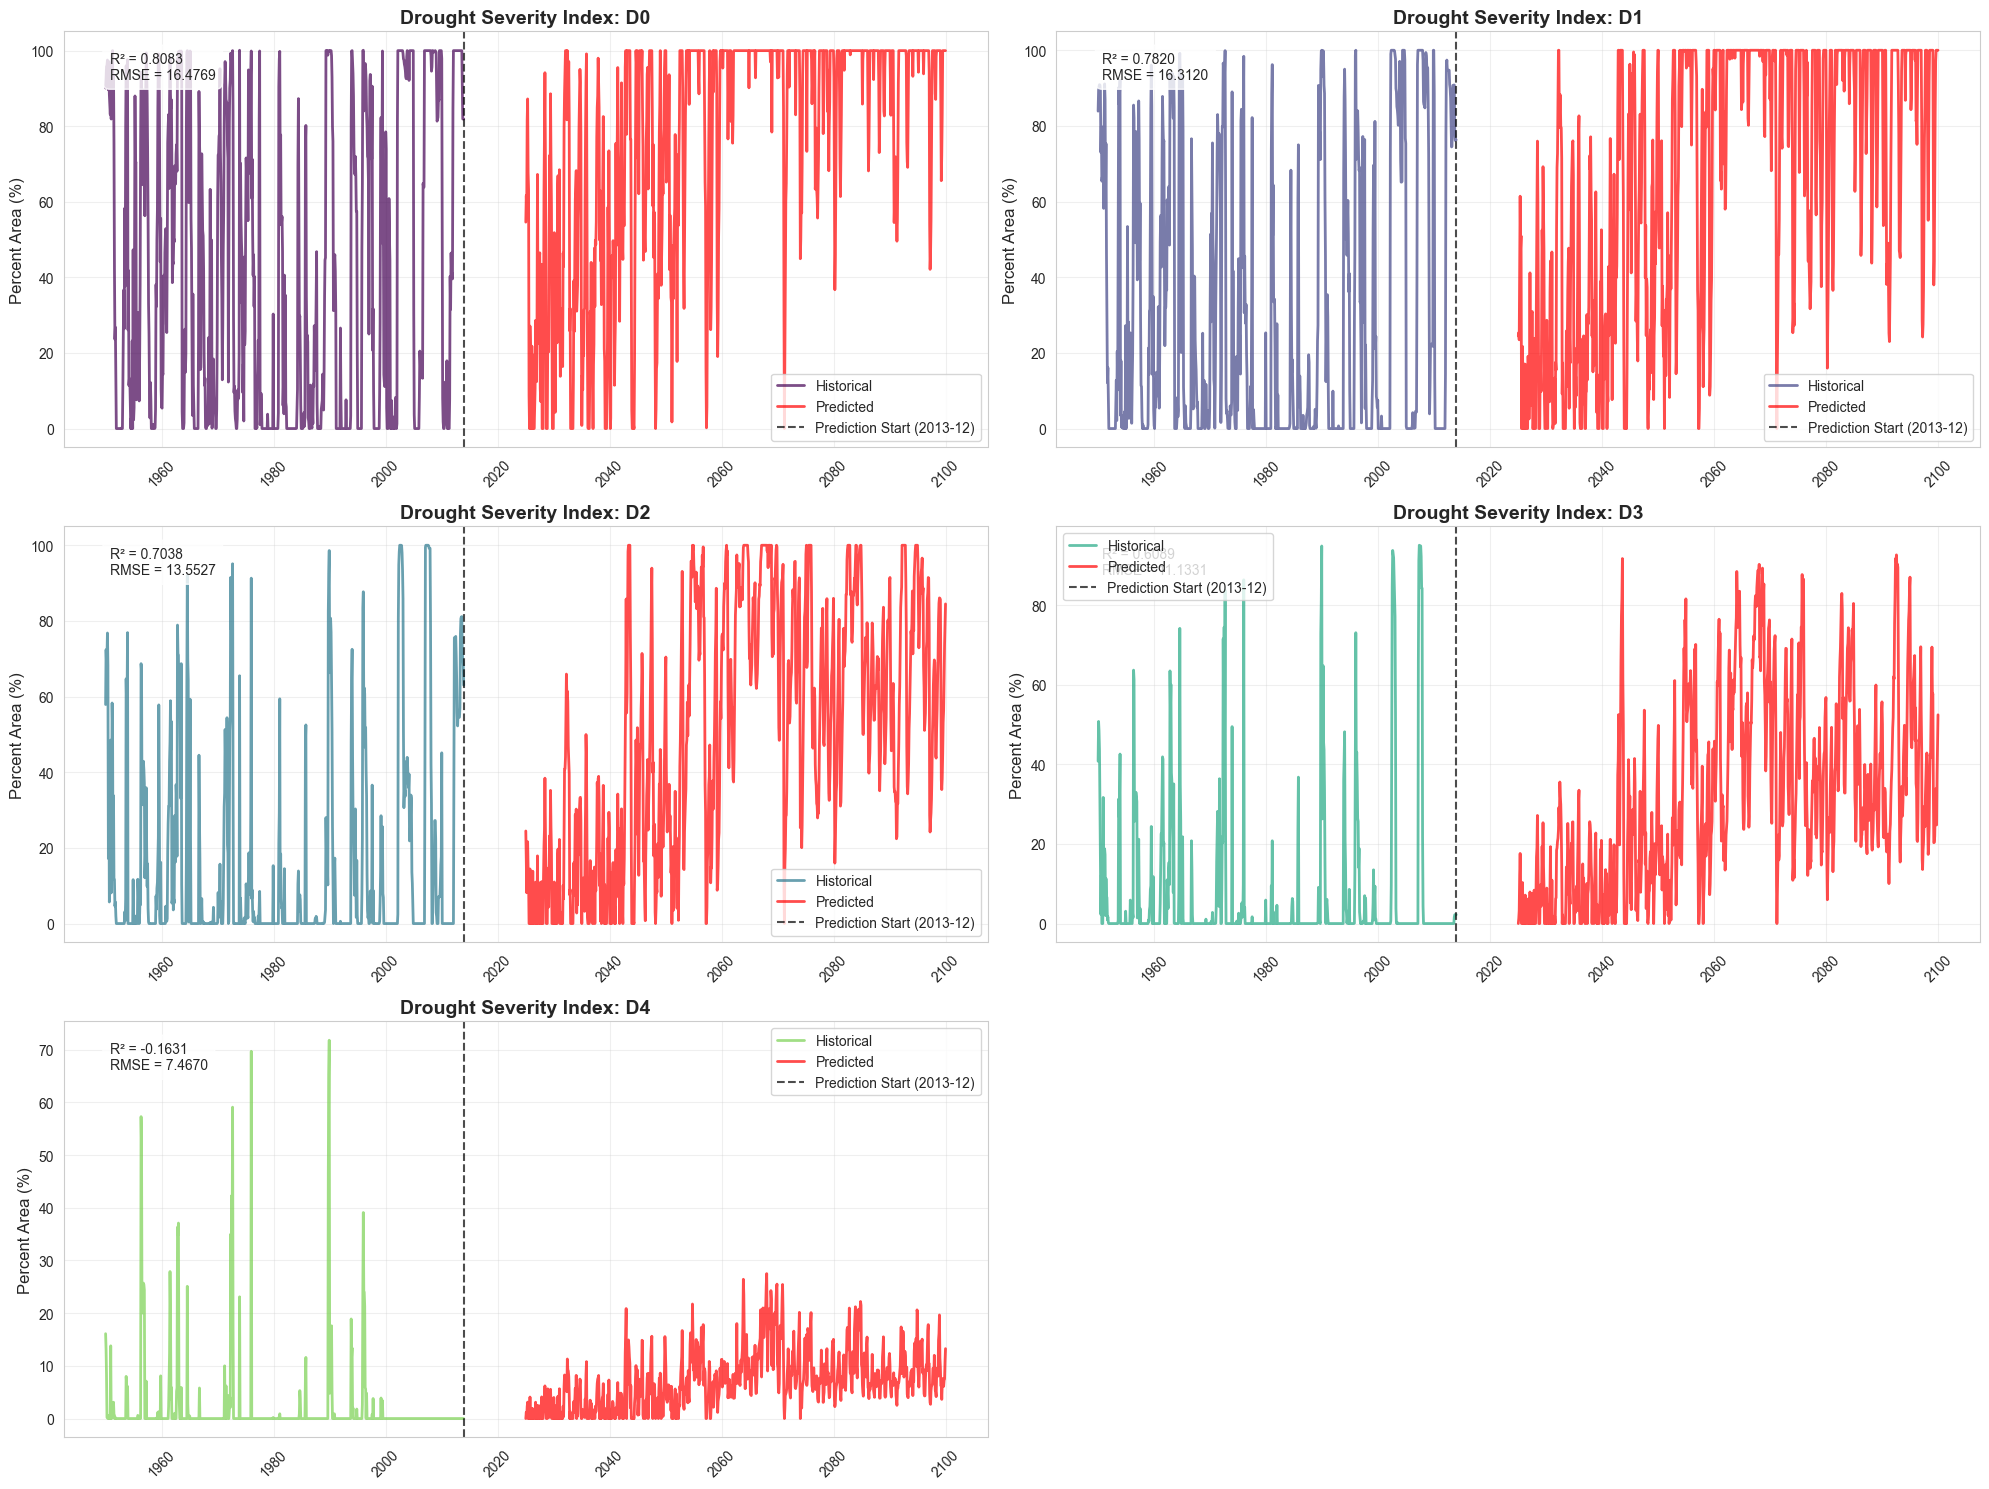

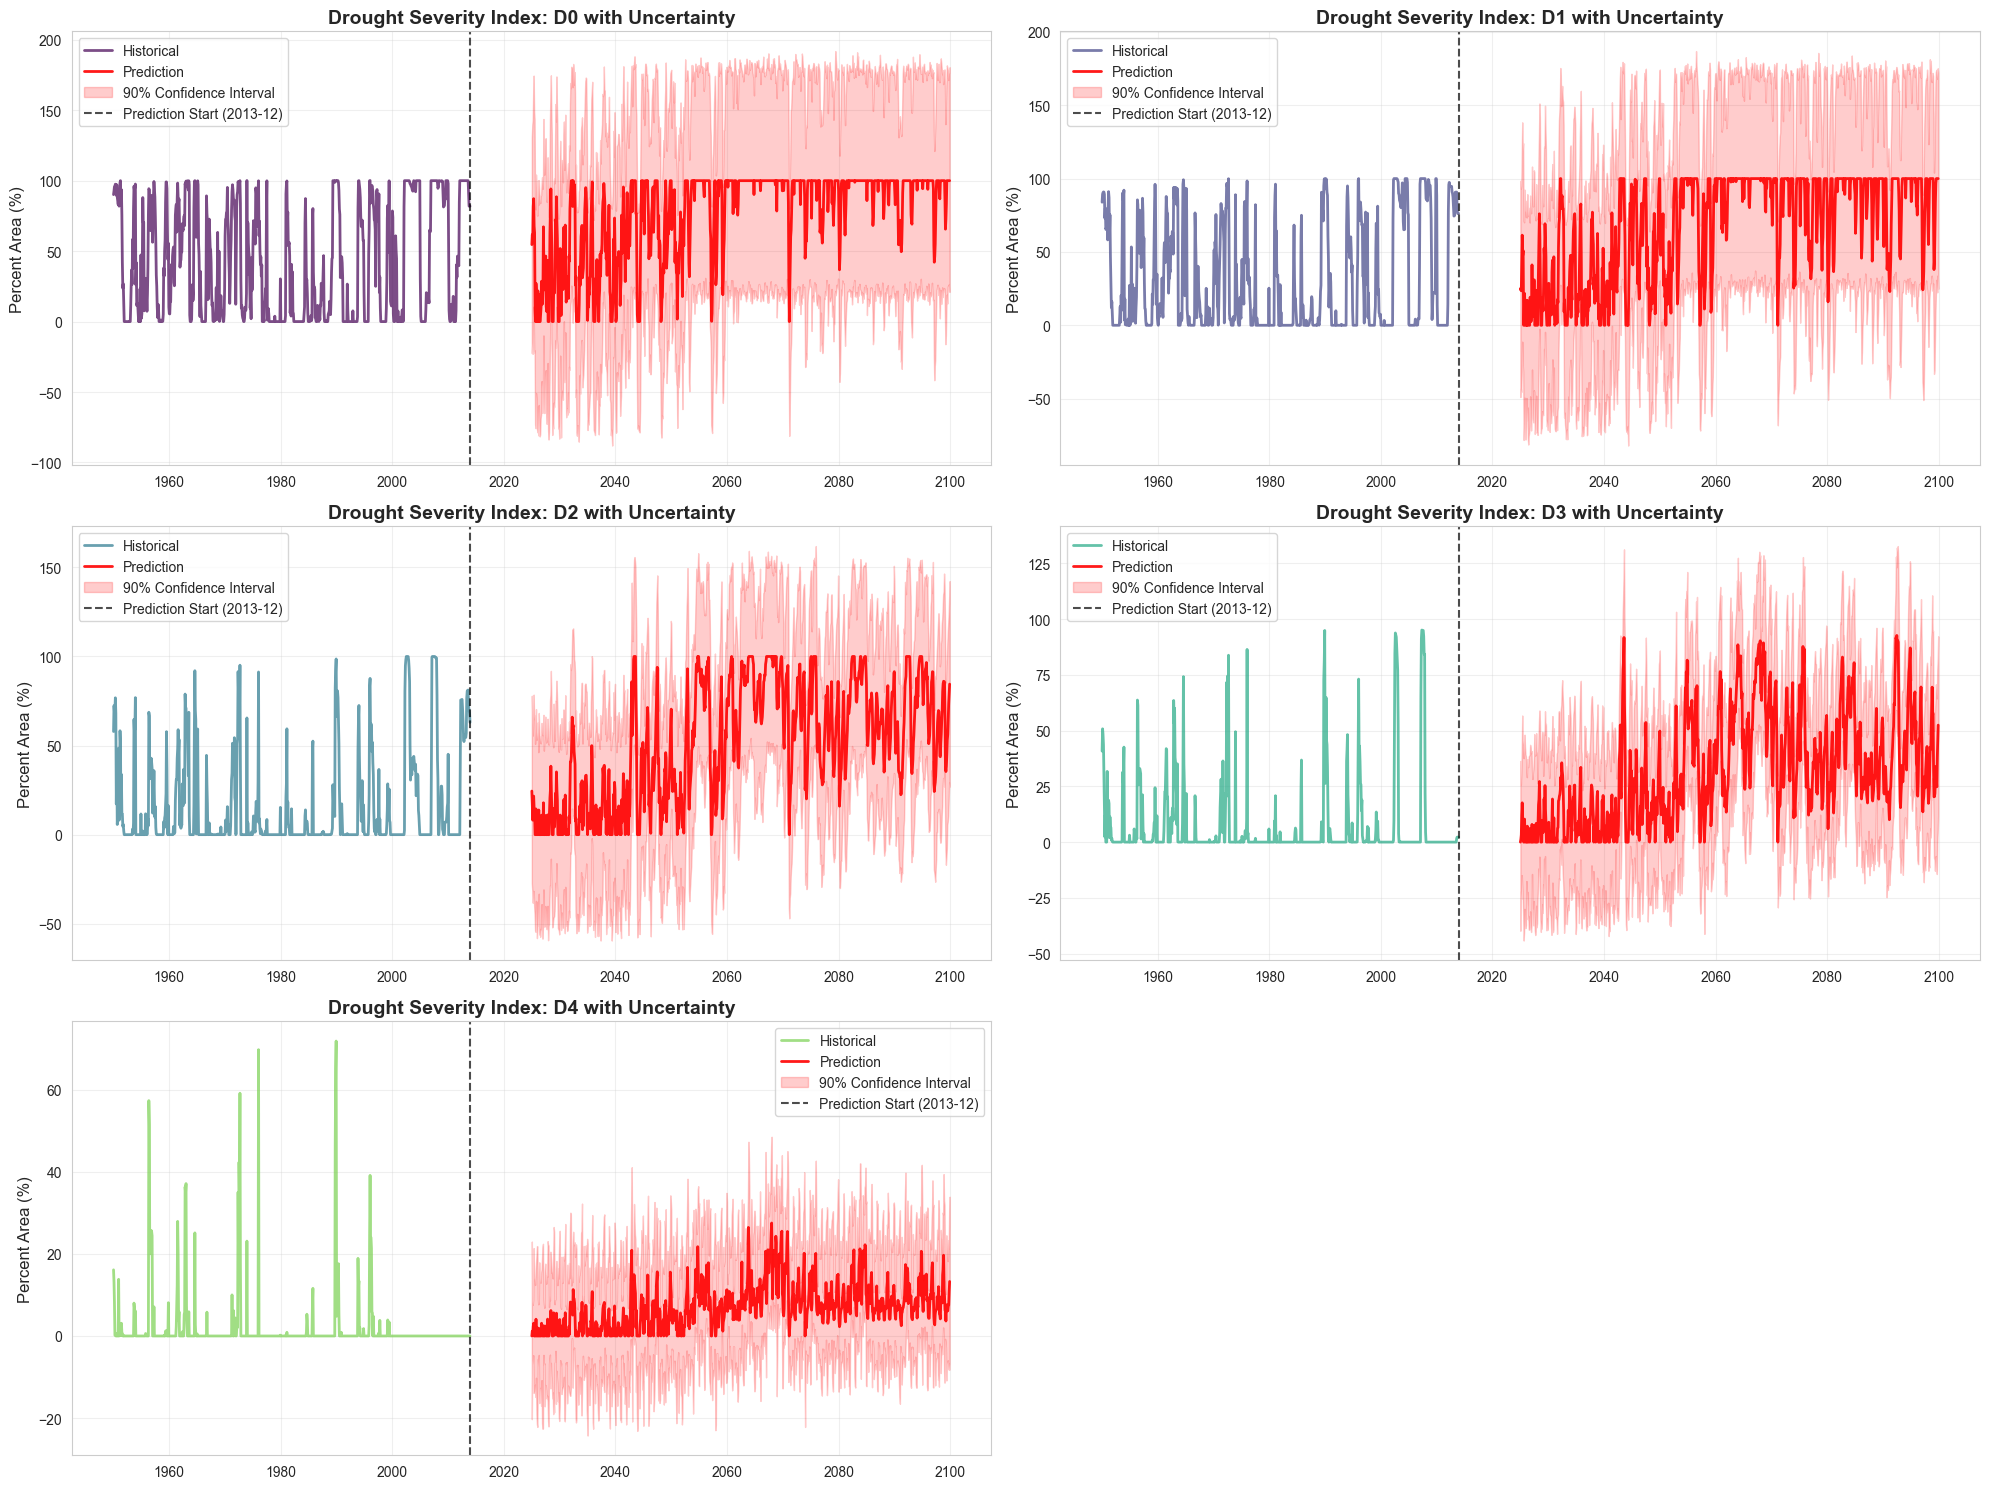

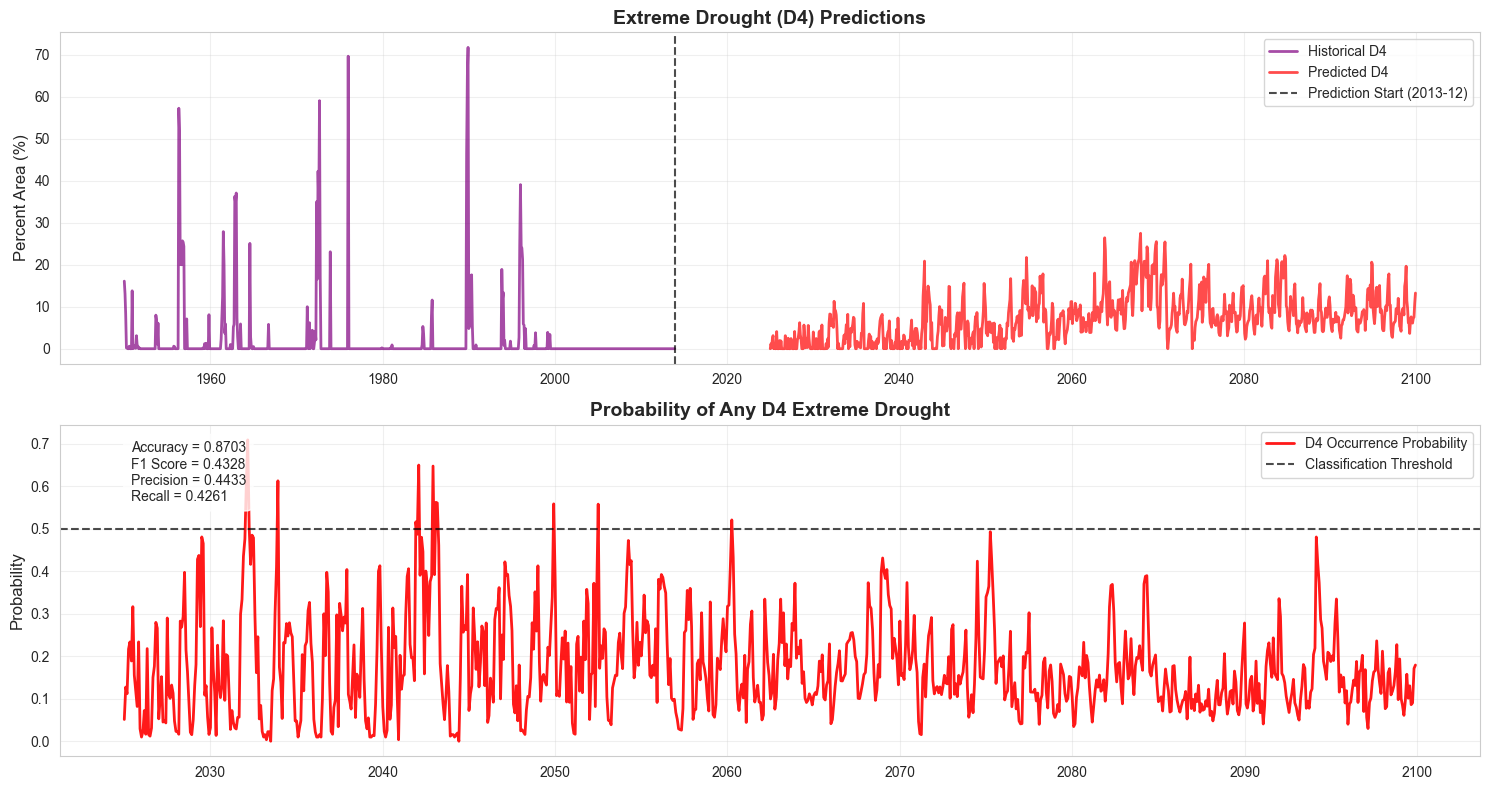

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit
import warnings
import time
import json
import os
warnings.filterwarnings('ignore')

# Import TreeFFuser
from treeffuser import Treeffuser
print("TreeFFuser successfully imported")

# Create directories for outputs
os.makedirs('model_cache', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Custom helper functions
def print_section(title):
    """Print a section header to make output more readable"""
    print("\n" + "="*80)
    print(f" {title} ".center(80, "="))
    print("="*80)

def format_date(date_str):
    """Standardize date formats from both datasets"""
    if len(date_str) <= 7:  # Format like '2025-01'
        return f"{date_str}-01"  # Add day to match historical format
    return date_str  # Already in full format

print_section("LOADING AND PREPARING DATA")

# Record start time for performance benchmarking
start_time = time.time()

# Load data files
historical_df = pd.read_csv('final_historical.csv')
future_df = pd.read_csv('future_all_df_wd_85.csv')

# Convert and standardize dates
historical_df['date'] = pd.to_datetime(historical_df['date'])
future_df['date'] = pd.to_datetime(future_df['date'].apply(format_date))

# Ensure historical data is sorted by date
historical_df = historical_df.sort_values('date')

# Filter historical data
min_year = 1950
max_year = 2013
historical_df = historical_df[(historical_df['date'].dt.year >= min_year) & 
                              (historical_df['date'].dt.year <= max_year)]

print(f"Historical data: {historical_df.shape[0]} rows from {historical_df['date'].min()} to {historical_df['date'].max()}")
print(f"Future data: {future_df.shape[0]} rows from {future_df['date'].min()} to {future_df['date'].max()}")

# Extract month and year as separate features - vectorized operations
historical_df['month'] = historical_df['date'].dt.month
historical_df['year'] = historical_df['date'].dt.year
future_df['month'] = future_df['date'].dt.month
future_df['year'] = future_df['date'].dt.year

# Create seasonal features (sine and cosine transformations)
for df in [historical_df, future_df]:
    # Convert month to a cyclical feature
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    # Add quarterly seasonal indicators
    df['quarter'] = ((df['month'] - 1) // 3) + 1
    for q in range(1, 5):
        df[f'quarter_{q}'] = (df['quarter'] == q).astype(int)

print_section("ENHANCED FEATURE ENGINEERING")

def create_lag_features(df, target_cols, lag_periods=[1, 2, 3, 6, 12, 24, 36], fill_method='monthly_mean'):
    """
    Create enhanced lag features for the target columns.
    
    Parameters:
    df: DataFrame with time-indexed data
    target_cols: List of columns to create features for (D0-D4)
    lag_periods: List of lag periods in months
    fill_method: Method to fill missing values ('monthly_mean' or 'forward_fill')
    
    Returns:
    DataFrame with added features
    """
    df = df.copy()
    
    # Ensure the dataframe is sorted by date
    df = df.sort_values('date')
    
    # Pre-calculate monthly means for filling
    if fill_method == 'monthly_mean':
        monthly_means = {col: df.groupby('month')[col].mean() for col in target_cols if col in df.columns}
    
    # Create lag features for each target column
    for col in target_cols:
        if col in df.columns:
            for lag in lag_periods:
                lag_col = f'{col}_lag_{lag}'
                df[lag_col] = df[col].shift(lag)
                
                # Fill missing values
                if fill_method == 'monthly_mean' and lag_col in df.columns:
                    # Use vectorized operations for faster filling
                    mask = df[lag_col].isna()
                    if mask.any():
                        df.loc[mask, lag_col] = df.loc[mask, 'month'].map(monthly_means[col])
                elif fill_method == 'forward_fill':
                    df[lag_col] = df[lag_col].ffill()
    
    # Create interaction features between meteorological variables
    for i, var1 in enumerate(['airtemp', 'rainfall', 'sm']):
        for j, var2 in enumerate(['baseflow', 'ev', 'runoff']):
            if i != j:  # Limit interactions to reduce dimensionality
                df[f'{var1}_{var2}_interaction'] = df[var1] * df[var2]
    
    # Add rolling mean features for climate variables
    for col in ['airtemp', 'rainfall', 'sm']:
        for window in [3, 6, 12]:
            df[f'{col}_roll_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
    
    # Add seasonal lag features (same month in previous years)
    for col in target_cols:
        if col in df.columns:
            for years_back in [1, 2, 3]:
                months_back = years_back * 12
                seasonal_lag_col = f'{col}_seasonal_lag_{years_back}y'
                df[seasonal_lag_col] = df[col].shift(months_back)
                
                # Fill missing values for seasonal lags
                if fill_method == 'monthly_mean':
                    mask = df[seasonal_lag_col].isna()
                    if mask.any():
                        df.loc[mask, seasonal_lag_col] = df.loc[mask, 'month'].map(monthly_means[col])
    
    return df

# Set up parameters
target_cols = ['D0', 'D1', 'D2', 'D3', 'D4']
enhanced_lag_periods = [1, 2, 3, 6, 12, 24, 36]  # Added 2-year and 3-year lags

# Apply enhanced feature engineering to historical data
historical_df_features = create_lag_features(historical_df, target_cols, enhanced_lag_periods)

# Print descriptive statistics of target columns
print("\nTarget variable statistics:")
for col in target_cols:
    stats = historical_df[col].describe()
    print(f"{col}: min={stats['min']:.2f}, max={stats['max']:.2f}, mean={stats['mean']:.2f}, median={stats['50%']:.2f}")

# Pre-calculate monthly patterns (vectorized operations)
monthly_means = {col: historical_df.groupby('month')[col].mean() for col in target_cols}
monthly_stds = {col: historical_df.groupby('month')[col].std() for col in target_cols}

# Create D4 binary classification target
historical_df_features['D4_binary'] = (historical_df_features['D4'] > 0).astype(int)
print(f"\nD4 binary class distribution: {historical_df_features['D4_binary'].value_counts()}")

# Check if any NaN values remain
nan_count = historical_df_features.isna().sum().sum()
if nan_count > 0:
    print(f"Warning: {nan_count} NaN values remain in the feature-engineered historical data")
    print(historical_df_features.isna().sum())
    # Drop rows with remaining NaN values as a last resort
    historical_df_features = historical_df_features.dropna()
    print(f"Dropped rows with NaN values. Remaining rows: {len(historical_df_features)}")
else:
    print("No NaN values in the feature-engineered historical data")

# Define feature columns
base_feature_cols = ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater']
seasonal_features = ['month_sin', 'month_cos', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4']
rolling_features = [col for col in historical_df_features.columns if '_roll_' in col]
interaction_features = [col for col in historical_df_features.columns if '_interaction' in col]
derived_feature_cols = [col for col in historical_df_features.columns 
                       if (('_lag_' in col or '_seasonal_lag_' in col) and 
                          col.split('_')[0] in target_cols)]

# Combine all feature columns
all_feature_cols = base_feature_cols + seasonal_features + rolling_features + interaction_features + derived_feature_cols

print(f"Total number of features: {len(all_feature_cols)}")
print(f"Base features: {len(base_feature_cols)}")
print(f"Seasonal features: {len(seasonal_features)}")
print(f"Rolling features: {len(rolling_features)}")
print(f"Interaction features: {len(interaction_features)}")
print(f"Derived features: {len(derived_feature_cols)}")

print_section("FEATURE IMPORTANCE ANALYSIS")

# Function to analyze feature importance and select top features
def analyze_feature_importance(X, y, feature_names, n_top=20):
    """Analyze feature importance using Random Forest"""
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X, y)
    
    # Get feature importances
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Print top features
    print("\nTop important features:")
    for i in range(min(n_top, len(feature_names))):
        print(f"  {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
    
    return indices, importances

# Prepare data for feature importance analysis
X_importance = historical_df_features[all_feature_cols]
feature_importance_results = {}
selected_features = {}

# Run feature importance for each target and select top features
for col in target_cols:
    print(f"\nFeature importance for {col}:")
    y_target = historical_df_features[col]
    indices, importances = analyze_feature_importance(X_importance, y_target, all_feature_cols)
    feature_importance_results[col] = (indices, importances)
    
    # Select top features for each target (adaptive feature selection)
    n_features = 30  # Maximum number of features to use
    # For D3 which had negative R², we'll use more selective feature selection
    if col == 'D3':
        n_features = 20
    
    # Select features with importance above a threshold
    threshold = 0.005  # Minimum importance to include feature
    important_indices = [i for i, imp in enumerate(importances) if imp > threshold][:n_features]
    selected_features[col] = [all_feature_cols[i] for i in important_indices]
    
    print(f"Selected {len(selected_features[col])} features for {col}")

print_section("TIME SERIES CROSS-VALIDATION")

# Set up time series cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Get unique years for splitting
years = historical_df_features['year'].unique()
years.sort()

# Calculate approximate split indices
split_years = []
year_interval = (years[-1] - years[0]) // n_splits
for i in range(n_splits - 1):
    split_year = years[0] + (i + 1) * year_interval
    split_years.append(split_year)

print(f"Time series cross-validation with {n_splits} splits")
print(f"Data from {years[0]} to {years[-1]}")
print(f"Approximate split years: {split_years}")

# Initialize dictionaries to store CV results
cv_results = {
    'r2': {col: [] for col in target_cols},
    'mae': {col: [] for col in target_cols},
    'mse': {col: [] for col in target_cols},
    'rmse': {col: [] for col in target_cols}
}

d4_binary_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

# Define a function to train regression models (using RandomForest instead of TreeFFuser due to type error)
def train_regression_model(X, y, col_name):
    """Train a regression model optimized for each target"""
    print(f"Training model for {col_name}...")
    
    # Determine optimal n_estimators based on target importance
    if col_name in ['D0', 'D1', 'D4']:
        n_estimators = 150  # Important targets get more estimators
    else:
        n_estimators = 100  # Less critical targets get fewer estimators
    
    # Create and train RandomForest model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=None,  # Allow deep trees for complex patterns
        min_samples_split=5,  # Minimum samples to consider splitting
        min_samples_leaf=2,   # Minimum samples in leaf nodes
        max_features='sqrt',  # Use square root of features for each split
        random_state=42,
        n_jobs=-1  # Use all cores
    )
    
    # Convert y to numpy array if it's pandas Series
    if isinstance(y, pd.Series):
        y = y.values
    
    model.fit(X, y)
    print(f"  Successfully trained with {n_estimators} estimators")
    return model

# Execute time series cross-validation
for i, (train_idx, test_idx) in enumerate(tscv.split(historical_df_features)):
    print(f"\nFold {i+1}/{n_splits}")
    
    # Extract train and test sets
    train_df = historical_df_features.iloc[train_idx]
    test_df = historical_df_features.iloc[test_idx]
    
    train_years = (train_df['year'].min(), train_df['year'].max())
    test_years = (test_df['year'].min(), test_df['year'].max())
    
    print(f"Train period: {train_years[0]}-{train_years[1]} ({len(train_df)} samples)")
    print(f"Test period: {test_years[0]}-{test_years[1]} ({len(test_df)} samples)")
    
    # Train and evaluate regression models for each target
    for col in target_cols:
        # Use selected features for each target
        X_train = train_df[selected_features[col]]
        y_train = train_df[col]
        X_test = test_df[selected_features[col]]
        y_test = test_df[col]
        
        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        model = train_regression_model(X_train_scaled, y_train, col)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        
        # Store results
        cv_results['r2'][col].append(r2)
        cv_results['mae'][col].append(mae)
        cv_results['mse'][col].append(mse)
        cv_results['rmse'][col].append(rmse)
        
        print(f"{col} results: R² = {r2:.4f}, MAE = {mae:.4f}, RMSE = {rmse:.4f}")
    
    # Train and evaluate D4 binary classification model
    X_train_bin = train_df[selected_features['D4']]
    y_train_bin = train_df['D4_binary']
    X_test_bin = test_df[selected_features['D4']]
    y_test_bin = test_df['D4_binary']
    
    # Scale features
    scaler_bin = StandardScaler()
    X_train_bin_scaled = scaler_bin.fit_transform(X_train_bin)
    X_test_bin_scaled = scaler_bin.transform(X_test_bin)
    
    # Train binary classifier for D4
    classifier = RandomForestClassifier(
        n_estimators=150, 
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',  # Handle class imbalance
        random_state=42,
        n_jobs=-1
    )
    classifier.fit(X_train_bin_scaled, y_train_bin)
    
    # Make predictions
    y_pred_bin = classifier.predict(X_test_bin_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_bin, y_pred_bin)
    precision = precision_score(y_test_bin, y_pred_bin, zero_division=0)
    recall = recall_score(y_test_bin, y_pred_bin, zero_division=0)
    f1 = f1_score(y_test_bin, y_pred_bin, zero_division=0)
    
    # Store results
    d4_binary_results['accuracy'].append(accuracy)
    d4_binary_results['precision'].append(precision)
    d4_binary_results['recall'].append(recall)
    d4_binary_results['f1'].append(f1)
    
    print(f"D4 Binary Classification: Accuracy = {accuracy:.4f}, F1 = {f1:.4f}")
    print(f"Precision = {precision:.4f}, Recall = {recall:.4f}")

# Calculate average CV metrics
avg_results = {
    'r2': {col: np.mean(cv_results['r2'][col]) for col in target_cols},
    'mae': {col: np.mean(cv_results['mae'][col]) for col in target_cols},
    'mse': {col: np.mean(cv_results['mse'][col]) for col in target_cols},
    'rmse': {col: np.mean(cv_results['rmse'][col]) for col in target_cols}
}

avg_d4_binary = {
    'accuracy': np.mean(d4_binary_results['accuracy']),
    'precision': np.mean(d4_binary_results['precision']),
    'recall': np.mean(d4_binary_results['recall']),
    'f1': np.mean(d4_binary_results['f1'])
}

# Print average results
print("\nAverage Cross-Validation Results:")
for col in target_cols:
    print(f"{col}: R² = {avg_results['r2'][col]:.4f}, MAE = {avg_results['mae'][col]:.4f}, RMSE = {avg_results['rmse'][col]:.4f}")

print(f"\nD4 Binary Classification: Accuracy = {avg_d4_binary['accuracy']:.4f}, F1 = {avg_d4_binary['f1']:.4f}")
print(f"Precision = {avg_d4_binary['precision']:.4f}, Recall = {avg_d4_binary['recall']:.4f}")

# Save metrics to JSON
metrics = {
    'regression': {
        'drought_indices': {col: {
            'r2': float(avg_results['r2'][col]),
            'mae': float(avg_results['mae'][col]),
            'mse': float(avg_results['mse'][col]),
            'rmse': float(avg_results['rmse'][col])
        } for col in target_cols}
    },
    'classification': {
        'D4_binary': {
            'accuracy': float(avg_d4_binary['accuracy']),
            'precision': float(avg_d4_binary['precision']),
            'recall': float(avg_d4_binary['recall']),
            'f1': float(avg_d4_binary['f1'])
        }
    },
    'model_details': {
        'time_period': f"{min_year}-{max_year}",
        'n_splits': n_splits,
        'features_count': {col: len(selected_features[col]) for col in target_cols}
    }
}

# Save metrics to file
with open('results/performance_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

print("\nPerformance metrics saved to 'results/performance_metrics.json'")

print_section("FINAL MODEL TRAINING AND PREDICTIONS")

# Train final models on the entire dataset
final_models = {}
final_scalers = {}

# Train regression models
for col in target_cols:
    # Use selected features for each target
    X_all = historical_df_features[selected_features[col]]
    y_all = historical_df_features[col]
    
    # Scale features
    scaler = StandardScaler()
    X_all_scaled = scaler.fit_transform(X_all)
    
    # Train model
    print(f"Training final model for {col}...")
    model = train_regression_model(X_all_scaled, y_all, col)
    
    # Store model and scaler
    final_models[col] = model
    final_scalers[col] = scaler

# Train binary classification model for D4
X_all_bin = historical_df_features[selected_features['D4']]
y_all_bin = historical_df_features['D4_binary']

# Scale features
scaler_bin = StandardScaler()
X_all_bin_scaled = scaler_bin.fit_transform(X_all_bin)

# Train model
print("Training final D4 binary classification model...")
classifier = RandomForestClassifier(
    n_estimators=150, 
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
classifier.fit(X_all_bin_scaled, y_all_bin)

def make_autoregressive_predictions(models, scalers, classifier, binary_scaler, 
                                   future_df, historical_df, target_cols, 
                                   selected_features):
    """Make autoregressive predictions with domain knowledge constraints."""
    print("\nStarting autoregressive prediction with domain knowledge...")
    
    # Create working copies
    historical_df = historical_df.copy()
    future_df = future_df.copy()
    
    # Add target columns to future_df
    for col in target_cols:
        if col not in future_df.columns:
            future_df[col] = np.nan
    
    # Combine historical and future data
    combined_df = pd.concat([historical_df, future_df], ignore_index=True)
    combined_df = combined_df.sort_values('date').reset_index(drop=True)
    
    print(f"Combined data shape: {combined_df.shape}")
    print(f"Prediction period: {future_df['date'].min()} to {future_df['date'].max()}")
    
    # Get index where future data starts
    future_start_idx = combined_df[combined_df['date'] >= future_df['date'].min()].index[0]
    print(f"Future data starts at index {future_start_idx}")
    
    # Pre-calculate monthly means and stds for constraints
    monthly_means = {col: historical_df.groupby('month')[col].mean() for col in target_cols}
    monthly_stds = {col: historical_df.groupby('month')[col].std() for col in target_cols}
    
    # Create temperature anomaly as a proxy for ENSO
    combined_df['temp_anomaly'] = combined_df.groupby('month')['airtemp'].transform(
        lambda x: x - x.mean()
    )
    combined_df['enso_effect'] = np.tanh(combined_df['temp_anomaly'])  # Bounded effect
    
    # Dictionary to store prediction statistics
    pred_stats = {col: [] for col in target_cols}
    
    # Process future data with autoregressive approach
    for i in range(future_start_idx, len(combined_df)):
        current_date = combined_df.loc[i, 'date']
        current_month = combined_df.loc[i, 'month']
        print(f"Predicting for {current_date.strftime('%Y-%m')}...", end=" ")
        
        # Update features based on previous predictions
        current_df = create_lag_features(
            combined_df.iloc[:i+1], 
            target_cols, 
            enhanced_lag_periods,
            fill_method='monthly_mean'
        )
        
        # Get the current row for prediction
        current_row = current_df.iloc[-1:]
        
        # Make predictions for each target
        for col in target_cols:
            try:
                # Extract features for this target
                model_features = [f for f in selected_features[col] if f in current_row.columns]
                
                # Extract feature values
                features = current_row[model_features].copy()
                
                # Scale the features
                scaler = final_scalers[col]
                features_scaled = scaler.transform(features)
                
                # Get the model
                model = final_models[col]
                
                # Make prediction
                prediction = model.predict(features_scaled)[0]
                
                # Apply constraints to ensure realistic predictions
                min_val = max(0, historical_df[col].min())
                max_val = min(100, historical_df[col].max())
                
                # Domain knowledge: Adjust for climate pattern effects like ENSO
                enso_effect = combined_df.loc[i, 'enso_effect']
                enso_adjustment = enso_effect * monthly_stds[col][current_month] * 0.5
                prediction += enso_adjustment
                
                # Domain knowledge: Ensure drought hierarchy D0 >= D1 >= D2 >= D3 >= D4
                if col == 'D1' and 'D0' in combined_df.columns:
                    prediction = min(prediction, combined_df.loc[i, 'D0'])
                elif col == 'D2' and 'D1' in combined_df.columns:
                    prediction = min(prediction, combined_df.loc[i, 'D1'])
                elif col == 'D3' and 'D2' in combined_df.columns:
                    prediction = min(prediction, combined_df.loc[i, 'D2'])
                elif col == 'D4' and 'D3' in combined_df.columns:
                    prediction = min(prediction, combined_df.loc[i, 'D3'])
                
                # Additional constraint: prediction should not change too dramatically
                if i > 0 and not pd.isna(combined_df.loc[i-1, col]):
                    prev_value = combined_df.loc[i-1, col]
                    month_std = monthly_stds[col][current_month]
                    
                    # Limit change based on seasonal volatility
                    max_change = 2.5 * month_std
                    prediction = max(prev_value - max_change, min(prev_value + max_change, prediction))
                
                # Final bounds check
                prediction = max(min_val, min(max_val, prediction))
                
                # Store the prediction
                combined_df.loc[i, col] = prediction
                pred_stats[col].append(prediction)
                
            except Exception as e:
                print(f"\nError predicting {col}: {str(e)}")
                # Use fallback value
                if i > 0 and not pd.isna(combined_df.loc[i-1, col]):
                    fallback_value = combined_df.loc[i-1, col]
                else:
                    fallback_value = monthly_means[col][current_month]
                
                combined_df.loc[i, col] = fallback_value
                pred_stats[col].append(fallback_value)
        
        # Make D4 binary prediction
        try:
            # Extract features for D4 binary classifier
            d4_features = current_row[selected_features['D4']].copy()
            
            # Scale features
            d4_features_scaled = binary_scaler.transform(d4_features)
            
            # Make binary prediction
            d4_binary_pred = classifier.predict(d4_features_scaled)[0]
            d4_binary_prob = classifier.predict_proba(d4_features_scaled)[0][1]
            
            # Adjust D4 regression based on binary prediction
            if d4_binary_pred == 1 and combined_df.loc[i, 'D4'] < 1.0:
                combined_df.loc[i, 'D4'] = max(combined_df.loc[i, 'D4'], 1.0)
            
            # Store binary prediction
            combined_df.loc[i, 'D4_binary_pred'] = d4_binary_pred
            combined_df.loc[i, 'D4_binary_prob'] = d4_binary_prob
            
        except Exception as e:
            print(f"\nError in D4 binary classification: {str(e)}")
            # Use regression-based classification as fallback
            combined_df.loc[i, 'D4_binary_pred'] = 1 if combined_df.loc[i, 'D4'] > 0 else 0
            combined_df.loc[i, 'D4_binary_prob'] = min(1.0, combined_df.loc[i, 'D4'] / 5.0)
        
        print("Done")
    
    print("\nPrediction complete.")
    
    # Return only the future predictions
    future_predictions = combined_df[combined_df['date'] >= future_df['date'].min()].copy()
    
    # Print prediction statistics
    print("\nPrediction statistics by target:")
    for col in target_cols:
        stats = {
            'mean': np.mean(pred_stats[col]),
            'std': np.std(pred_stats[col]),
            'min': np.min(pred_stats[col]),
            'max': np.max(pred_stats[col])
        }
        print(f"{col}: mean={stats['mean']:.2f}, std={stats['std']:.2f}, min={stats['min']:.2f}, max={stats['max']:.2f}")
    
    # Final check for any remaining NaN values
    for col in target_cols:
        nan_mask = future_predictions[col].isna()
        nan_count = nan_mask.sum()
        
        if nan_count > 0:
            print(f"Warning: {nan_count} NaN values in {col} predictions. Filling with seasonal means.")
            
            # Use vectorized operations for faster filling
            month_values = future_predictions.loc[nan_mask, 'month']
            month_means = [monthly_means[col][m] for m in month_values]
            future_predictions.loc[nan_mask, col] = month_means
    
    # Final consistency check: ensure drought hierarchy is maintained
    print("\nApplying final consistency constraints...")
    for i, row in future_predictions.iterrows():
        for j in range(1, len(target_cols)):
            current_col = target_cols[j]
            prev_col = target_cols[j-1]
            if row[current_col] > row[prev_col]:
                future_predictions.loc[i, current_col] = future_predictions.loc[i, prev_col]
    
    return future_predictions

# Make predictions using the final models
print("\nGenerating future predictions with enhanced model...")
# Apply feature engineering to future data
future_df_features = create_lag_features(future_df, target_cols, enhanced_lag_periods, fill_method='monthly_mean')

future_predictions = make_autoregressive_predictions(
    final_models, final_scalers, classifier, scaler_bin,
    future_df, historical_df, target_cols, 
    selected_features
)

# Save predictions to CSV
future_predictions.to_csv('results/future_drought_predictions.csv', index=False)
print("Predictions saved to 'results/future_drought_predictions.csv'")

print_section("VISUALIZATION AND ANALYSIS")

# Create enhanced visualizations
plt.figure(figsize=(20, 15))

# Set a modern aesthetic style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

cmap = plt.cm.get_cmap('viridis')
colors = [cmap(i/len(target_cols)) for i in range(len(target_cols))]

for i, (col, color) in enumerate(zip(target_cols, colors)):
    plt.subplot(3, 2, i+1)
    
    # Plot historical data
    plt.plot(historical_df['date'], historical_df[col], 
             color=color, alpha=0.7, linewidth=2, label='Historical')
    
    # Plot predictions
    plt.plot(future_predictions['date'], future_predictions[col], 
             color='red', alpha=0.7, linewidth=2, linestyle='-', label='Predicted')
    
    # Add a vertical line at the transition point
    transition_date = historical_df['date'].max()
    plt.axvline(x=transition_date, color='black', linestyle='--', alpha=0.7,
               label=f'Prediction Start ({transition_date.strftime("%Y-%m")})')
    
    # Add average CV R² to the plot
    r2_value = avg_results['r2'][col]
    rmse_value = avg_results['rmse'][col]
    
    plt.title(f'Drought Severity Index: {col}', fontsize=14, fontweight='bold')
    plt.ylabel('Percent Area (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add annotations
    textstr = f'R² = {r2_value:.4f}\nRMSE = {rmse_value:.4f}'
    props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
    plt.annotate(textstr, xy=(0.05, 0.95), xycoords='axes fraction',
                 fontsize=10, verticalalignment='top', bbox=props)
    
    # Customize date axis
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('results/RF_drought_predictions.png', dpi=300, bbox_inches='tight')
print("Visualization saved to 'results/RF_drought_predictions.png'")

# Create uncertainty visualization with bootstrap samples
plt.figure(figsize=(20, 15))

# Generate bootstrap samples for uncertainty visualization
bootstrap_samples = {}
n_bootstrap = 1000

for col in target_cols:
    # Get monthly std values for each month in future_predictions
    month_stds = future_predictions['month'].map(monthly_stds[col])
    
    # Generate bootstrap samples from predictions with monthly-specific std
    samples = np.random.normal(
        loc=future_predictions[col].values, 
        scale=month_stds.values * 1.2,  # Slightly increase uncertainty for future predictions
        size=(n_bootstrap, len(future_predictions))
    )
    
    # Store for plotting
    bootstrap_samples[col] = samples

for i, (col, color) in enumerate(zip(target_cols, colors)):
    plt.subplot(3, 2, i+1)
    
    # Get precomputed samples
    samples = bootstrap_samples[col]
    
    # Calculate quantiles from bootstrap samples
    lower_quantile = np.percentile(samples, 5, axis=0)
    upper_quantile = np.percentile(samples, 95, axis=0)
    
    # Plot historical data
    plt.plot(historical_df['date'], historical_df[col], 
            color=color, alpha=0.7, linewidth=2, label='Historical')
    
    # Plot prediction mean
    plt.plot(future_predictions['date'], future_predictions[col], 
            color='red', alpha=0.9, linewidth=2, label='Prediction')
    
    # Plot uncertainty band
    plt.fill_between(future_predictions['date'], lower_quantile, upper_quantile, 
                    color='red', alpha=0.2, label='90% Confidence Interval')
    
    # Add a vertical line at the transition point
    transition_date = historical_df['date'].max()
    plt.axvline(x=transition_date, color='black', linestyle='--', alpha=0.7,
              label=f'Prediction Start ({transition_date.strftime("%Y-%m")})')
    
    plt.title(f'Drought Severity Index: {col} with Uncertainty', fontsize=14, fontweight='bold')
    plt.ylabel('Percent Area (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.savefig('results/drought_predictions_uncertainty.png', dpi=300, bbox_inches='tight')
print("Uncertainty visualization saved to 'results/drought_predictions_uncertainty.png'")

# Special visualization for D4 binary classification
plt.figure(figsize=(15, 8))

# Plot D4 actual values
plt.subplot(2, 1, 1)
plt.plot(historical_df['date'], historical_df['D4'], 
        color='purple', alpha=0.7, linewidth=2, label='Historical D4')
plt.plot(future_predictions['date'], future_predictions['D4'], 
        color='red', alpha=0.7, linewidth=2, label='Predicted D4')
plt.axvline(x=transition_date, color='black', linestyle='--', alpha=0.7,
          label=f'Prediction Start ({transition_date.strftime("%Y-%m")})')
plt.title('Extreme Drought (D4) Predictions', fontsize=14, fontweight='bold')
plt.ylabel('Percent Area (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Plot D4 binary classification (probability)
plt.subplot(2, 1, 2)
plt.plot(future_predictions['date'], future_predictions['D4_binary_prob'], 
        color='red', alpha=0.9, linewidth=2, label='D4 Occurrence Probability')

# Add horizontal threshold line
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.7, label='Classification Threshold')

plt.title('Probability of Any D4 Extreme Drought', fontsize=14, fontweight='bold')
plt.ylabel('Probability', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Add D4 binary classification metrics
textstr = (f'Accuracy = {avg_d4_binary["accuracy"]:.4f}\n'
           f'F1 Score = {avg_d4_binary["f1"]:.4f}\n'
           f'Precision = {avg_d4_binary["precision"]:.4f}\n'
           f'Recall = {avg_d4_binary["recall"]:.4f}')
props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
plt.annotate(textstr, xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=10, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('results/d4_binary_classification.png', dpi=300, bbox_inches='tight')
print("D4 binary classification visualization saved to 'results/d4_binary_classification.png'")

# Calculate execution time
end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal execution time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

print("\nEnhanced drought prediction model completed.")